# ML MB model with custom loss function for predicting MB on monthly resolution

Based on tests performed in notebook test_custom_loss.ipynb

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import BaseCrossValidator
from sklearn.inspection import permutation_importance
from sklearn.utils.validation import check_is_fitted

from model_classes import CustomXGBRegressor

from helpers import reshape_dataset_monthly
from helpers import get_prediction_per_season
from helpers import get_prediction_per_season_test

from data_processing import get_ann_seas_train_test_datasets

#from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_train_val_counts
from plotting_functions import plot_feature_distributions
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_gsearch_results_mod
from plotting_functions import plot_prediction
from plotting_functions import plot_prediction_subplot
from plotting_functions import plot_prediction_per_season
from plotting_functions import plot_feature_importance
from plotting_functions import plot_permutation_importance_per_fold


## 1 Prepare training and test data

In [2]:
# Specify filepaths and filenames         
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

# Load data
data = pd.read_csv(filepath + filename)

# Define test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get train and test datasets
datasets_train, datasets_test = get_ann_seas_train_test_datasets(data, test_glaciers)


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_10212\4140151468.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [40]:
df_train_annual = datasets_train['train_annual']
df_train_winter = datasets_train['train_winter']
df_train_summer = datasets_train['train_summer']
df_test_annual = datasets_test['test_annual']
df_test_winter = datasets_test['test_winter']
df_test_summer = datasets_test['test_summer']

# Remove strange values
df_test_winter = df_test_winter[df_test_winter['balance_winter'] != 9.99].reset_index(drop=True)

df_test_winter

#cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
#        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
#        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
#        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
#        'topo','dis_from_border', 'lat','lon', 'slope_factor']

#snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
#snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
#evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
#snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
#snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
#snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
#snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
#snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
#snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
#dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
#surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
#sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
#sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
#u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
#v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

RGIID         GLIMSID  BREID  utm_zone  utm_east_approx  \
0    RGI60-08.01258  G021737E70130N     54        34         529400.0   
1    RGI60-08.01258  G021737E70130N     54        34         529400.0   
2    RGI60-08.01258  G021737E70130N     54        34         529400.0   
3    RGI60-08.01258  G021737E70130N     54        34         529400.0   
4    RGI60-08.01258  G021737E70130N     54        34         529400.0   
..              ...             ...    ...       ...              ...   
994  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
995  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
996  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
997  RGI60-08.02969  G006362E59989N   3141        32         351800.0   
998  RGI60-08.02969  G006362E59989N   3141        32         351800.0   

     utm_north_approx  altitude_approx location_description location_id  \
0           7780050.0            500.0  Nederst på bretunga         L10   
1           7780050.0            500.0  Nederst på bretunga         L10   
2           7780050.0            500.0  Nederst på bretunga         L10   
3           7780050.0            500.0  Nederst på bretunga         L10   
4           7780050.0            500.0  Nederst på bretunga         L10   
..                ...              ...                  ...         ...   
994         6647500.0           1080.0  Nederst på bretunga         B15   
995         6647500.0           1080.0  Nederst på bretunga         B15   
996         6647500.0           1080.0  Nederst på bretunga         B15   
997         6647500.0           1080.0  Nederst på bretunga         B15   
998         6647500.0           1080.0  Nederst på bretunga         B15   

    stake_no  ...    tp_apr    tp_may    tp_jun    tp_jul    tp_aug    tp_sep  \
0      L1012  ...  0.002334  0.001159  0.003054  0.003977  0.004691  0.001449   
1      L1013  ...  0.005634  0.002244  0.003412  0.000891  0.002129  0.004860   
2      L1013  ...  0.003739  0.004709  0.005111  0.001253  0.002506  0.003256   
3      L1013  ...  0.001256  0.002129  0.003969  0.003559  0.002119  0.002851   
4      L1016  ...  0.002704  0.003991  0.001780  0.004257  0.005193  0.000710   
..       ...  ...       ...       ...       ...       ...       ...       ...   
994    B1509  ...  0.003555  0.005019  0.004730  0.007226  0.005739  0.011397   
995    B1509  ...  0.009360  0.006135  0.006760  0.005158  0.008218  0.005461   
996    B1514  ...  0.006261  0.008175  0.005974  0.006563  0.008015  0.003896   
997    B1514  ...  0.004573  0.004449  0.005235  0.008926  0.011151  0.009556   
998    B1514  ...  0.007457  0.003567  0.008162  0.007537  0.007390  0.006440   

    altitude_climate skyview_factor  year n_months  
0         341.227919       0.778997  2013        7  
1         341.227919       0.798494  2014        7  
2         341.227919       0.803510  2015        7  
3         341.227919       0.803510  2016        7  
4         341.227919       0.817480  2017        7  
..               ...            ...   ...      ...  
994       917.419759       0.932281  2012        7  
995       917.419759       0.932281  2013        7  
996       917.419759       0.932281  2015        7  
997       917.419759       0.932281  2016        7  
998       917.419759       0.932281  2017        7  

[999 rows x 304 columns]

In [41]:
# Select features
id_vars_ext = ['BREID', 'year', 'altitude', 'altitude_climate', 'balance_netto', 'balance_summer', 'balance_winter','aspect','slope','skyview_factor','n_months']
# Includes RGIID for model comparison
id_vars_ext_test = ['BREID', 'RGIID', 'year', 'altitude', 'altitude_climate', 'balance_netto', 'balance_summer', 'balance_winter','aspect','slope','skyview_factor','n_months']
climate_vars = ['t2m_', 'sshf_', 'slhf_', 'ssrd_', 'fal_','str_', 'tp_']

season = 'annual'

def prepare_features(df, season, id_vars_ext, climate_vars, drop_altitude=True):
    
    # Select features for training
    cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in climate_vars) or col in id_vars_ext]
    df_clean = df[cols]

    # For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
    # For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
    mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
    mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']

    # Get target column and rename to same name
    if season == 'annual':
        df_clean = df_clean.drop(['balance_winter','balance_summer'], axis=1)
        df_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
        
    elif season == 'winter':
        df_clean = df_clean.drop(['balance_netto', 'balance_summer'], axis=1)
        df_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)

        for name in climate_vars:
            for mon in mon_summer:
                if mon not in mon_winter:
                    df_clean[name+mon]= np.nan
        
    elif season == 'summer':
        df_clean = df_clean.drop(['balance_netto', 'balance_winter'], axis=1)
        df_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

        for name in climate_vars:   
            for mon in mon_winter:
                if mon not in mon_summer:
                    df_clean[name+mon]= np.nan

    # Use altitude_diff instead of altitude and altitude_climate
    df_clean['altitude_diff'] = df_clean['altitude_climate']-df_clean['altitude']

    if drop_altitude==True:
        df_clean = df_clean.drop(['altitude','altitude_climate'], axis=1)

    df_clean = df_clean.dropna(axis=1, how='all')

    return df_clean

# Get features for datasets
df_train_annual_clean = prepare_features(df_train_annual, 'annual', id_vars_ext, climate_vars)
df_train_winter_clean = prepare_features(df_train_winter, 'winter', id_vars_ext, climate_vars)
df_train_summer_clean = prepare_features(df_train_summer, 'summer', id_vars_ext, climate_vars)

df_test_annual_clean = prepare_features(df_test_annual, 'annual', id_vars_ext_test, climate_vars, drop_altitude=False)
df_test_winter_clean = prepare_features(df_test_winter, 'winter', id_vars_ext_test, climate_vars, drop_altitude=False)
df_test_summer_clean = prepare_features(df_test_summer, 'summer', id_vars_ext_test, climate_vars, drop_altitude=False)


In [30]:
df_train_summer_clean

BREID  balance    aspect     slope     t2m_may     t2m_jun     t2m_jul  \
172     596    -3.41  2.509464  0.238202  274.658875  274.336243  277.882172   
173     596    -2.16  2.474161  0.117946  272.144592  273.530029  277.322693   
174     596    -2.90  2.509464  0.238202  269.770782  276.377563  280.937714   
175     596    -3.16  2.478294  0.146882  271.778687  274.179108  277.781219   
176     596    -1.90  2.478294  0.146882  269.576447  274.819061  276.495239   
...     ...      ...       ...       ...         ...         ...         ...   
3728   3129    -2.35  2.115165  0.111223  273.900482  278.282257  281.753021   
3729   3129    -1.29  2.312361  0.097301  275.172058  276.951477  279.342773   
3730   3129    -1.80  2.482095  0.070551  274.379517  277.572449  280.500458   
3731   3129    -2.81  2.339748  0.073072  274.581451  280.670502  281.674072   
3732   3129    -1.19  2.526225  0.068208  274.327118  277.050171  278.294403   

         t2m_aug     t2m_sep   fal_may  ...   ssrd_sep    tp_may    tp_jun  \
172   281.432678  276.588593  0.596335  ...  6023235.0  0.001702  0.001953   
173   278.478851  272.429291  0.723258  ...  6095838.5  0.002906  0.003402   
174   278.349060  270.681732  0.737786  ...  6222793.0  0.003094  0.001567   
175   280.827637  277.611938  0.719680  ...  5031936.5  0.000861  0.004021   
176   277.525391  274.129761  0.757669  ...  7607123.0  0.001514  0.004824   
...          ...         ...       ...  ...        ...       ...       ...   
3728  284.041077  280.659119  0.581270  ...  8312470.0  0.003067  0.004948   
3729  280.883057  277.482117  0.605599  ...  8409815.0  0.005468  0.009837   
3730  280.890656  279.949310  0.582101  ...  7716636.0  0.001531  0.006192   
3731  281.446350  277.422150  0.573719  ...  6327439.0  0.004337  0.003802   
3732  280.939240  280.146698  0.618479  ...  8269476.0  0.004908  0.007480   

        tp_jul    tp_aug    tp_sep  skyview_factor  year  n_months  \
172   0.004025  0.002591  0.006047        0.883281  1963         5   
173   0.003066  0.004062  0.004951        0.957209  1964         5   
174   0.003896  0.004033  0.004845        0.883281  1966         5   
175   0.006549  0.003302  0.003687        0.960949  1967         5   
176   0.003683  0.004470  0.001097        0.960949  1968         5   
...        ...       ...       ...             ...   ...       ...   
3728  0.001373  0.001677  0.008620        0.953703  1968         5   
3729  0.010945  0.007251  0.008933        0.969350  1964         5   
3730  0.002394  0.006272  0.007284        0.966856  1965         5   
3731  0.004859  0.004397  0.011932        0.968909  1966         5   
3732  0.006605  0.006391  0.005946        0.971815  1967         5   

      altitude_diff  
172       11.181943  
173        5.181943  
174       13.181943  
175       11.181943  
176       11.181943  
...             ...  
3728    -556.166788  
3729    -576.166788  
3730    -592.166788  
3731    -595.166788  
3732    -592.166788  

[2901 rows x 43 columns]

In [49]:
df_test_summer_clean

RGIID  BREID  altitude  balance    aspect     slope  \
0     RGI60-08.01258     54     471.0    -6.24  0.629597  0.278773   
1     RGI60-08.01258     54     439.0    -4.35  0.585924  0.296590   
2     RGI60-08.01258     54     444.0    -4.17  0.663261  0.302508   
3     RGI60-08.01258     54     444.0    -4.37  0.663261  0.302508   
4     RGI60-08.01258     54     468.0    -4.05  0.836757  0.309196   
...              ...    ...       ...      ...       ...       ...   
3924  RGI60-08.02969   3141    1078.0    -3.57  2.906044  0.131717   
3925  RGI60-08.02969   3141    1078.0    -4.29  2.906044  0.131717   
3926  RGI60-08.02969   3141    1079.0    -3.80  2.906044  0.131717   
3927  RGI60-08.02969   3141    1078.0    -4.38  2.906044  0.131717   
3928  RGI60-08.02969   3141    1078.0    -4.44  2.906044  0.131717   

         t2m_may     t2m_jun     t2m_jul     t2m_aug  ...    tp_may    tp_jun  \
0     277.677979  283.339630  283.829285  283.778412  ...  0.001159  0.003054   
1     273.853424  278.533508  286.991089  283.409485  ...  0.002244  0.003412   
2     275.326904  277.934570  282.700439  284.425964  ...  0.004709  0.005111   
3     277.405426  279.781555  284.442657  282.017212  ...  0.002129  0.003969   
4     272.579590  278.621582  283.518036  282.460541  ...  0.003991  0.001780   
...          ...         ...         ...         ...  ...       ...       ...   
3924  276.051880  279.342010  282.147797  282.897827  ...  0.005019  0.004730   
3925  277.164032  280.542206  284.284760  282.710297  ...  0.006135  0.006760   
3926  274.069031  278.133453  281.378021  283.121002  ...  0.008175  0.005974   
3927  278.187347  283.209045  282.545563  282.466614  ...  0.004449  0.005235   
3928  277.690887  280.319031  282.416504  281.939026  ...  0.003567  0.008162   

        tp_jul    tp_aug    tp_sep  altitude_climate  skyview_factor  year  \
0     0.003977  0.004691  0.001449        341.227919        0.778997  2013   
1     0.000891  0.002129  0.004860        341.227919        0.798494  2014   
2     0.001253  0.002506  0.003256        341.227919        0.803510  2015   
3     0.003559  0.002119  0.002851        341.227919        0.803510  2016   
4     0.004257  0.005193  0.000710        341.227919        0.817480  2017   
...        ...       ...       ...               ...             ...   ...   
3924  0.007226  0.005739  0.011397        917.419759        0.932281  2012   
3925  0.005158  0.008218  0.005461        917.419759        0.932281  2013   
3926  0.006563  0.008015  0.003896        917.419759        0.932281  2015   
3927  0.008926  0.011151  0.009556        917.419759        0.932281  2016   
3928  0.007537  0.007390  0.006440        917.419759        0.932281  2017   

      n_months  altitude_diff  
0            5    -129.772081  
1            5     -97.772081  
2            5    -102.772081  
3            5    -102.772081  
4            5    -126.772081  
...        ...            ...  
3924         5    -160.580241  
3925         5    -160.580241  
3926         5    -161.580241  
3927         5    -160.580241  
3928         5    -160.580241  

[1028 rows x 46 columns]

### 1.1 Prepare training data

In [31]:
'''
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

#drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
#                         dewpt_temp, surface_pressure, sol_therm_down, u_wind, v_wind] for y in x]
#drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
#                         dewpt_temp, surface_pressure, sol_rad_down, sol_therm_down, u_wind, v_wind, f_albedo] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#var = ['t2m', 'sshf', 'slhf', 'ssr','ssrd','fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']#,'may']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

# Use altitude_diff instead of altitude and altitude_climate
df_train_summer_clean['altitude_diff'] = df_train_summer_clean['altitude_climate']-df_train_summer_clean['altitude']
df_train_winter_clean['altitude_diff'] = df_train_winter_clean['altitude_climate']-df_train_winter_clean['altitude']
df_train_annual_clean['altitude_diff'] = df_train_annual_clean['altitude_climate']-df_train_annual_clean['altitude']

df_train_summer_clean = df_train_summer_clean.drop(['altitude','altitude_climate'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['altitude','altitude_climate'], axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['altitude','altitude_climate'], axis=1)

df_train_summer_clean = df_train_summer_clean.dropna(axis=1, how='all')
df_train_winter_clean = df_train_winter_clean.dropna(axis=1, how='all')
df_train_annual_clean = df_train_annual_clean.dropna(axis=1, how='all')
'''

In [ ]:
# Assign Ids for each target
n_summer = len(df_train_summer_clean)
n_winter = len(df_train_winter_clean)
n_annual = len(df_train_annual_clean)

df_train_summer_clean.insert(0, 'id', list(range(n_summer)))
df_train_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_train_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))


In [ ]:
id_vars = ['id','BREID', 'year', 'altitude_diff','balance','aspect','slope','skyview_factor','n_months']
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']

# Order of months
summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']#,'may']
annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape dataframes to monthly resolution
df_train_summer_final = reshape_dataset_monthly(df_train_summer_clean, id_vars, variables, summer_months_order)
df_train_winter_final = reshape_dataset_monthly(df_train_winter_clean, id_vars, variables, winter_months_order)
df_train_annual_final = reshape_dataset_monthly(df_train_annual_clean, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_final.reset_index(drop=True, inplace=True)
df_train_winter_final.reset_index(drop=True, inplace=True)
df_train_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_final, df_train_winter_final, df_train_annual_final]
df_train_final = pd.concat(data_list)

df_train_final.reset_index(drop=True, inplace=True)

check_nan = df_train_final.isna().sum()
if check_nan != 0:
    print(check_nan)

df_train_final

In [8]:
# add sshf and sslf variables
#df_train_final['sthf'] = df_train_final['sshf']+df_train_final['slhf']
#df_train_final = df_train_final.drop(columns=['sshf','slhf'])
#df_train_final

In [9]:
#df_train_final.to_csv('Data/old_data/' + 'dataset_norway_monthly.csv', index=None)

### 1.2 Prepare test data

In [48]:
'''# Prepare test

# Cols to drop for test
# DOES NOT INCLUDE RGIID BECAUSE THIS IS NEEDED FOR MODEL COMPARISON
cols_test = ['GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border', 'lat','lon', 'slope_factor']
drop_cols_test = [y for x in [cols_test, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]
#drop_cols_test = [y for x in [cols_test, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
#                         dewpt_temp, surface_pressure, sol_therm_down, u_wind, v_wind] for y in x]
#drop_cols_test = [y for x in [cols_test, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
#                         dewpt_temp, surface_pressure, sol_rad_down, sol_therm_down, u_wind, v_wind, f_albedo] for y in x]

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols_test, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols_test, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols_test, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
#var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
#mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

# INCLUDES RGIID BECAUSE THIS IS NEEDED FOR MODEL COMPARISON
id_vars_test = ['id','BREID', 'RGIID', 'year', 'altitude_diff','altitude','altitude_climate','balance','aspect','slope','skyview_factor','n_months']
#id_vars_test = ['id','BREID', 'RGIID', 'year', 'altitude_diff','altitude','altitude_climate','balance','aspect','slope','cidx','n_months']

for name in var:
    for mon in mon_summer:
        if mon not in mon_winter:
            df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        if mon not in mon_summer:
            df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
#df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
#df_test_all.reset_index(drop=True, inplace=True)

# Use altitude_diff instead of altitude and altitude_climate
# DO NOT DROP ALTITUDE AND ALTITUDE CLIMATE, NEEDED IN SAVED DATASET
df_test_summer_clean['altitude_diff'] = df_test_summer_clean['altitude_climate']-df_test_summer_clean['altitude']
#df_test_summer_clean = df_test_summer_clean.drop(['altitude','altitude_climate'], axis=1)
df_test_winter_clean['altitude_diff'] = df_test_winter_clean['altitude_climate']-df_test_winter_clean['altitude']
#df_test_winter_clean = df_test_winter_clean.drop(['altitude','altitude_climate'], axis=1)
df_test_annual_clean['altitude_diff'] = df_test_annual_clean['altitude_climate']-df_test_annual_clean['altitude']
#df_test_annual_clean = df_test_annual_clean.drop(['altitude','altitude_climate'], axis=1)

df_test_summer_clean = df_test_summer_clean.dropna(axis=1, how='all')
df_test_winter_clean = df_test_winter_clean.dropna(axis=1, how='all')
df_test_annual_clean = df_test_annual_clean.dropna(axis=1, how='all')

df_test_summer_clean
'''

RGIID  BREID  altitude  balance    aspect     slope  \
0     RGI60-08.01258     54     471.0    -6.24  0.629597  0.278773   
1     RGI60-08.01258     54     439.0    -4.35  0.585924  0.296590   
2     RGI60-08.01258     54     444.0    -4.17  0.663261  0.302508   
3     RGI60-08.01258     54     444.0    -4.37  0.663261  0.302508   
4     RGI60-08.01258     54     468.0    -4.05  0.836757  0.309196   
...              ...    ...       ...      ...       ...       ...   
3924  RGI60-08.02969   3141    1078.0    -3.57  2.906044  0.131717   
3925  RGI60-08.02969   3141    1078.0    -4.29  2.906044  0.131717   
3926  RGI60-08.02969   3141    1079.0    -3.80  2.906044  0.131717   
3927  RGI60-08.02969   3141    1078.0    -4.38  2.906044  0.131717   
3928  RGI60-08.02969   3141    1078.0    -4.44  2.906044  0.131717   

         t2m_may     t2m_jun     t2m_jul     t2m_aug  ...    tp_may    tp_jun  \
0     277.677979  283.339630  283.829285  283.778412  ...  0.001159  0.003054   
1     273.853424  278.533508  286.991089  283.409485  ...  0.002244  0.003412   
2     275.326904  277.934570  282.700439  284.425964  ...  0.004709  0.005111   
3     277.405426  279.781555  284.442657  282.017212  ...  0.002129  0.003969   
4     272.579590  278.621582  283.518036  282.460541  ...  0.003991  0.001780   
...          ...         ...         ...         ...  ...       ...       ...   
3924  276.051880  279.342010  282.147797  282.897827  ...  0.005019  0.004730   
3925  277.164032  280.542206  284.284760  282.710297  ...  0.006135  0.006760   
3926  274.069031  278.133453  281.378021  283.121002  ...  0.008175  0.005974   
3927  278.187347  283.209045  282.545563  282.466614  ...  0.004449  0.005235   
3928  277.690887  280.319031  282.416504  281.939026  ...  0.003567  0.008162   

        tp_jul    tp_aug    tp_sep  altitude_climate  skyview_factor  year  \
0     0.003977  0.004691  0.001449        341.227919        0.778997  2013   
1     0.000891  0.002129  0.004860        341.227919        0.798494  2014   
2     0.001253  0.002506  0.003256        341.227919        0.803510  2015   
3     0.003559  0.002119  0.002851        341.227919        0.803510  2016   
4     0.004257  0.005193  0.000710        341.227919        0.817480  2017   
...        ...       ...       ...               ...             ...   ...   
3924  0.007226  0.005739  0.011397        917.419759        0.932281  2012   
3925  0.005158  0.008218  0.005461        917.419759        0.932281  2013   
3926  0.006563  0.008015  0.003896        917.419759        0.932281  2015   
3927  0.008926  0.011151  0.009556        917.419759        0.932281  2016   
3928  0.007537  0.007390  0.006440        917.419759        0.932281  2017   

      n_months  altitude_diff  
0            5    -129.772081  
1            5     -97.772081  
2            5    -102.772081  
3            5    -102.772081  
4            5    -126.772081  
...        ...            ...  
3924         5    -160.580241  
3925         5    -160.580241  
3926         5    -161.580241  
3927         5    -160.580241  
3928         5    -160.580241  

[1028 rows x 46 columns]

In [ ]:
n_summer = len(df_test_summer_clean)
n_winter = len(df_test_winter_clean)
n_annual = len(df_test_annual_clean)

df_test_summer_clean.insert(0, 'id', list(range(n_summer)))
df_test_winter_clean.insert(0, 'id', list(range(n_summer, n_summer+n_winter)))
df_test_annual_clean.insert(0, 'id', list(range(n_summer+n_winter, n_summer+n_winter+n_annual)))

# Columns that are not monthly climate variables (identifiers and static variables)
#id_vars = ['id','BREID', 'year', 'altitude','balance','aspect','slope','altitude_climate','n_months']

# Extract the unique variable names and month names from the column names
#variables = set(col.split('_')[0] for col in df.columns if col not in id_vars)
#months = set(col.split('_')[-1] for col in df.columns if col not in id_vars)
#variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#summer_months_order = ['may', 'jun', 'jul', 'aug', 'sep']
#winter_months_order = ['oct','nov','dec','jan','feb','mar','apr']
#annual_months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape datasets to monthly resolution
df_test_summer_final = reshape_dataset_monthly(df_test_summer_clean, id_vars_test, variables, summer_months_order)
df_test_winter_final = reshape_dataset_monthly(df_test_winter_clean, id_vars_test, variables, winter_months_order)
df_test_annual_final = reshape_dataset_monthly(df_test_annual_clean, id_vars_test, variables, annual_months_order)

# Combine training data in one dataframe
df_test_summer_final.reset_index(drop=True, inplace=True)
df_test_winter_final.reset_index(drop=True, inplace=True)
df_test_annual_final.reset_index(drop=True, inplace=True)

data_list = [df_test_summer_final, df_test_winter_final, df_test_annual_final]
df_test_final = pd.concat(data_list)
df_test_final

In [12]:
df_test_final.columns

Index(['id', 'BREID', 'RGIID', 'year', 'altitude_diff', 'altitude',
       'altitude_climate', 'balance', 'aspect', 'slope', 'skyview_factor',
       'n_months', 'month', 't2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp'],
      dtype='object')

In [13]:
df_test_final.reset_index(drop=True, inplace=True)

In [14]:
# Save test dataset
#filename_test = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test_svf.csv'
#df_test_final.to_csv(filepath+filename_test)

In [15]:
df_test_final = df_test_final.drop(['RGIID','altitude','altitude_climate'], axis=1)

df_test_final

id  BREID  year  altitude_diff  balance    aspect     slope  \
0         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
1         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
2         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
3         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
4         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
...     ...    ...   ...            ...      ...       ...       ...   
24915  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24916  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24917  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24918  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24919  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   

       skyview_factor  n_months month         t2m          sshf       slhf  \
0            0.778997         5   may  277.677979  4.286715e+05  -237874.5   
1            0.778997         5   jun  283.339630 -2.133166e+06 -4024573.5   
2            0.778997         5   jul  283.829285 -2.731458e+06 -5184939.5   
3            0.778997         5   aug  283.778412 -1.295387e+06 -3545874.5   
4            0.778997         5   sep  280.982513  9.352438e+03 -1756179.5   
...               ...       ...   ...         ...           ...        ...   
24915        0.932281        12   may  277.690887 -5.189375e+02   -71670.0   
24916        0.932281        12   jun  280.319031  1.046328e+05  -101796.5   
24917        0.932281        12   jul  282.416504 -2.174798e+06 -4535185.5   
24918        0.932281        12   aug  281.939026 -1.997971e+06 -3884410.5   
24919        0.932281        12   sep  280.775269 -9.919489e+05 -2517502.0   

             ssrd       fal         str        tp  
0      20979516.0  0.580414 -3367191.50  0.001159  
1      17728592.0  0.198752 -3994740.00  0.003054  
2      15538729.0  0.131911 -4661453.00  0.003977  
3      10510849.0  0.130799 -4018348.50  0.004691  
4       6908671.0  0.130148 -4441106.50  0.001449  
...           ...       ...         ...       ...  
24915  17926120.0  0.530146 -2093793.25  0.003567  
24916  13385372.0  0.480811   162197.00  0.008162  
24917  15446657.0  0.183955 -3726261.25  0.007537  
24918  11212546.0  0.135438 -3417520.00  0.007390  
24919   7614423.5  0.133470 -3192232.00  0.006440  

[24920 rows x 17 columns]

In [16]:
# Remove strange values
df_test_final = df_test_final[df_test_final['balance'] != 9.99].reset_index(drop=True)

In [17]:
df_test_final

id  BREID  year  altitude_diff  balance    aspect     slope  \
0         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
1         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
2         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
3         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
4         0     54  2013    -129.772081    -6.24  0.629597  0.278773   
...     ...    ...   ...            ...      ...       ...       ...   
24908  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24909  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24910  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24911  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   
24912  3092   3141  2017    -160.580241    -3.29  2.906044  0.131717   

       skyview_factor  n_months month         t2m          sshf       slhf  \
0            0.778997         5   may  277.677979  4.286715e+05  -237874.5   
1            0.778997         5   jun  283.339630 -2.133166e+06 -4024573.5   
2            0.778997         5   jul  283.829285 -2.731458e+06 -5184939.5   
3            0.778997         5   aug  283.778412 -1.295387e+06 -3545874.5   
4            0.778997         5   sep  280.982513  9.352438e+03 -1756179.5   
...               ...       ...   ...         ...           ...        ...   
24908        0.932281        12   may  277.690887 -5.189375e+02   -71670.0   
24909        0.932281        12   jun  280.319031  1.046328e+05  -101796.5   
24910        0.932281        12   jul  282.416504 -2.174798e+06 -4535185.5   
24911        0.932281        12   aug  281.939026 -1.997971e+06 -3884410.5   
24912        0.932281        12   sep  280.775269 -9.919489e+05 -2517502.0   

             ssrd       fal         str        tp  
0      20979516.0  0.580414 -3367191.50  0.001159  
1      17728592.0  0.198752 -3994740.00  0.003054  
2      15538729.0  0.131911 -4661453.00  0.003977  
3      10510849.0  0.130799 -4018348.50  0.004691  
4       6908671.0  0.130148 -4441106.50  0.001449  
...           ...       ...         ...       ...  
24908  17926120.0  0.530146 -2093793.25  0.003567  
24909  13385372.0  0.480811   162197.00  0.008162  
24910  15446657.0  0.183955 -3726261.25  0.007537  
24911  11212546.0  0.135438 -3417520.00  0.007390  
24912   7614423.5  0.133470 -3192232.00  0.006440  

[24913 rows x 17 columns]

In [18]:
# add sshf and sslf variables
#df_test_final['sthf'] = df_test_final['sshf']+df_test_final['slhf']
#df_test_final = df_test_final.drop(columns=['sshf','slhf'])
#df_test_final

## 2 Split training data for cross validation

In [19]:
# Select features for training
df_train_X_reduce = df_train_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y = df_train_final[['balance']]

# Get arrays of features+metadata and targets
#X_train_unnorm, y_train = df_train_X.values, df_train_y.values
X_train, y_train = df_train_X.values, df_train_y.values

In [20]:
# Normalize features
# Using min-max scaling
#from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
#scaler = MinMaxScaler()

# Extract metadata columns
#metadata_columns = X_train_unnorm[:, -3:]

# Extract remaining columns
#remaining_columns = X_train_unnorm[:, :-3]

# Apply MinMaxScaler to the remaining columns
#scaled_remaining_columns = scaler.fit_transform(remaining_columns)

# Combine scaled columns with metadata columns
#X_train = np.hstack((scaled_remaining_columns, metadata_columns))

# Apply to validation/test data
#X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)

In [21]:
# USING CUSTOM ITERATOR TO SPLIT ON YEAR INTERVALS
'''
# Define the year intervals for the folds
year_intervals = [
    (1960, 1969),  # Fold 1
    (1970, 1979),  # Fold 2
    (1980, 1994),  # Fold 3
    (1995, 2009),  # Fold 4
    (2010, 2021)   # Fold 5
]

# Add a 'fold' column based on the 'year' intervals
def assign_fold(row):
    for i, (start_year, end_year) in enumerate(year_intervals):
        if start_year <= row['year'] <= end_year:
            return i
    return -1  # Return -1 if year is not in any interval (should not happen)

df_train_final['fold'] = df_train_final.apply(assign_fold, axis=1)

# Verify that all rows have been assigned a valid fold
if (df_train_final['fold'] == -1).any():
    raise ValueError("Some rows have not been assigned a valid fold")

# Group by 'id' to maintain groups of rows with the same 'id'
grouped = df_train_final.groupby('id')

# Create indices for each fold
folds = [([], []) for _ in range(5)]  # Initialize with 5 empty train/test index lists

# Distribute groups into folds
for _, group in grouped:
    fold = group['fold'].iloc[0]  # All rows in group have the same fold
    for fold_idx in range(5):
        if fold == fold_idx:
            folds[fold_idx][1].extend(group.index)  # Assign group to test set of this fold
        else:
            folds[fold_idx][0].extend(group.index)  # Assign group to train set of other folds

# Convert lists to numpy arrays
folds = [(np.array(train_indices), np.array(test_indices)) for train_indices, test_indices in folds]


## Splitting the DataFrame into folds for cross-validation
#folds = []
#for fold in range(5):
#    train_indices = df[df['fold'] != fold].index
#    test_indices = df[df['fold'] == fold].index
#    folds.append((train_indices, test_indices))

# Fold iterator function
#def get_fold_iterator(data, folds):
#    for train_indices, test_indices in folds:
#        yield data.iloc[train_indices], data.iloc[test_indices]

# Define the custom cross-validator
class CustomFoldIterator(BaseCrossValidator):
    def __init__(self, fold_indices):
        self.fold_indices = fold_indices

    def split(self, X, y=None, groups=None):
        for train_indices, test_indices in self.fold_indices:
            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.fold_indices)

# Setup and Execute GridSearchCV
custom_cv = CustomFoldIterator(folds)

# Create splits
splits_s = list(custom_cv.split(X_train, y_train))

# Convert Int64Index to numpy arrays 
splits_s = [(np.array(train_indices), np.array(test_indices)) for (train_indices, test_indices) in splits_s]

# Print number of instances in each split
for i, (train_indices, test_indices) in enumerate(splits_s):
    print(f"Fold {i+1} - Train: {len(train_indices)}, Test: {len(test_indices)}")

# Check fold indices for training/validation data
fold_indices = []

for i, (train_index, val_index) in enumerate(splits_s):
    print(f"Fold {i+1}")
    print("TRAIN:", train_index)
    print("VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "shape(validation):", val_index.shape)
    fold_indices.append((train_index, val_index))
    '''

'\n# Define the year intervals for the folds\nyear_intervals = [\n    (1960, 1969),  # Fold 1\n    (1970, 1979),  # Fold 2\n    (1980, 1994),  # Fold 3\n    (1995, 2009),  # Fold 4\n    (2010, 2021)   # Fold 5\n]\n\n# Add a \'fold\' column based on the \'year\' intervals\ndef assign_fold(row):\n    for i, (start_year, end_year) in enumerate(year_intervals):\n        if start_year <= row[\'year\'] <= end_year:\n            return i\n    return -1  # Return -1 if year is not in any interval (should not happen)\n\ndf_train_final[\'fold\'] = df_train_final.apply(assign_fold, axis=1)\n\n# Verify that all rows have been assigned a valid fold\nif (df_train_final[\'fold\'] == -1).any():\n    raise ValueError("Some rows have not been assigned a valid fold")\n\n# Group by \'id\' to maintain groups of rows with the same \'id\'\ngrouped = df_train_final.groupby(\'id\')\n\n# Create indices for each fold\nfolds = [([], []) for _ in range(5)]  # Initialize with 5 empty train/test index lists\n\n# Dis

In [22]:
# USING CUSTOM ITERATOR TO SPLIT ON CYCLE OF YEARS

# Add a 'fold' column to `df_train_final`, initializing to -1
df_train_final['fold'] = -1

# Get sorted list of unique years in the dataset
unique_years = df_train_final['year'].sort_values().unique()

# Round-robin assignment of years to folds
n_folds = 5
for fold, year in enumerate(unique_years):
    df_train_final.loc[df_train_final['year'] == year, 'fold'] = fold % n_folds

# Verify that all rows have been assigned a valid fold
if (df_train_final['fold'] == -1).any():
    raise ValueError("Some rows have not been assigned a valid fold")

# Group by 'id' to maintain groups of rows with the same 'id'
grouped = df_train_final.groupby('id')

# Initialize folds with 5 empty train/test index lists
folds = [([], []) for _ in range(n_folds)]

# Distribute groups into folds
for _, group in grouped:
    fold = group['fold'].iloc[0]  # All rows in group have the same fold
    for fold_idx in range(n_folds):
        if fold == fold_idx:
            folds[fold_idx][1].extend(group.index)  # Assign group to test set of this fold
        else:
            folds[fold_idx][0].extend(group.index)  # Assign group to train set of other folds

# Convert lists to numpy arrays
folds = [(np.array(train_indices), np.array(test_indices)) for train_indices, test_indices in folds]

# Custom cross-validator definition
class CustomFoldIterator(BaseCrossValidator):
    def __init__(self, fold_indices):
        self.fold_indices = fold_indices

    def split(self, X, y=None, groups=None):
        for train_indices, test_indices in self.fold_indices:
            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.fold_indices)

# Setup and Execute GridSearchCV (example)
custom_cv = CustomFoldIterator(folds)

# Create splits
splits_s = list(custom_cv.split(X_train, y_train))

# Print number of instances in each split
for i, (train_indices, test_indices) in enumerate(splits_s):
    print(f"Fold {i+1} - Train: {len(train_indices)}, Test: {len(test_indices)}")

# Check fold indices for training/validation data and extract years
fold_indices = []
for i, (train_index, val_index) in enumerate(splits_s):
    print(f"\nFold {i+1}")
    
    # Extract and sort years from train and validation sets
    train_years = np.sort(df_train_final.loc[train_index, 'year'].unique())
    val_years = np.sort(df_train_final.loc[val_index, 'year'].unique())
    
    print(f"TRAIN: {train_index}")
    print(f"VALIDATION: {val_index}")
    print(f"shape(train): {train_index.shape}, shape(validation): {val_index.shape}")
    
    print(f"Number of unique YEARS in TRAIN set: {len(train_years)}, Years: {train_years}")
    print(f"Number of unique YEARS in VALIDATION set: {len(val_years)}, Years: {val_years}")
    
    fold_indices.append((train_index, val_index))
# Check fold indices for training/validation data
#fold_indices = []
#for i, (train_index, val_index) in enumerate(splits_s):
#    print(f"Fold {i+1}")
#    print("TRAIN:", train_index)
#    print("VALIDATION:", val_index)
#    print("shape(train):", train_index.shape, "shape(validation):", val_index.shape)
#    fold_indices.append((train_index, val_index))


Fold 1 - Train: 53833, Test: 14076
Fold 2 - Train: 54663, Test: 13246
Fold 3 - Train: 54985, Test: 12924
Fold 4 - Train: 53621, Test: 14288
Fold 5 - Train: 54534, Test: 13375

Fold 1
TRAIN: [    0     1     2 ... 67894 67895 67896]
VALIDATION: [   15    16    17 ... 67906 67907 67908]
shape(train): (53833,), shape(validation): (14076,)
Number of unique YEARS in TRAIN set: 48, Years: [1963 1964 1965 1966 1968 1969 1970 1971 1973 1974 1975 1976 1978 1979
 1980 1981 1983 1984 1985 1986 1988 1989 1990 1991 1993 1994 1995 1996
 1998 1999 2000 2001 2003 2004 2005 2006 2008 2009 2010 2011 2013 2014
 2015 2016 2018 2019 2020 2021]
Number of unique YEARS in VALIDATION set: 12, Years: [1962 1967 1972 1977 1982 1987 1992 1997 2002 2007 2012 2017]

Fold 2
TRAIN: [    5     6     7 ... 67906 67907 67908]
VALIDATION: [    0     1     2 ... 67858 67859 67860]
shape(train): (54663,), shape(validation): (13246,)
Number of unique YEARS in TRAIN set: 48, Years: [1962 1964 1965 1966 1967 1969 1970 1971 19

In [23]:
# Using GroupKFold to split on id
'''
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_final['id'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train, y_train, gp_s))

#print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
#print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
#print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
#print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
#print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
#print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
#print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
#print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
#print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
#print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))
print(len(gp_s))
print(y_train.shape)
print(X_train.shape)
print(df_train_X.columns)
print(df_train_y.columns)

# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf.split(X_train, y_train, gp_s):
    print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))
    '''

'\n# Get glacier IDs from training dataset (in the order of which they appear in training dataset).\n# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.\ngp_s = np.array(df_train_final[\'id\'].values)\n\n# Use five folds\ngroup_kf = GroupKFold(n_splits=5)\n\n# Split into folds according to group by glacier ID.\n# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.\nsplits_s = list(group_kf.split(X_train, y_train, gp_s))\n\n#print(\'Train, fold 0: \', np.unique(gp_s[splits_s[0][0]]))\n#print(\'Validation, fold 0: \', np.unique(gp_s[splits_s[0][1]]))\n#print(\'Train, fold 1: \', np.unique(gp_s[splits_s[1][0]]))\n#print(\'Validation, fold 1: \', np.unique(gp_s[splits_s[1][1]]))\n#print(\'Train, fold 2: \', np.unique(gp_s[splits_s[2][0]]))\n#print(\'Validation, fold 2: \', np.unique(gp_s[splits_s[2][1]]))\n#print(\'Train, fold 3: \', np.unique(gp_s[splits_s[3][0]]))\n#print(\'Validation, fold 3: \', np.u

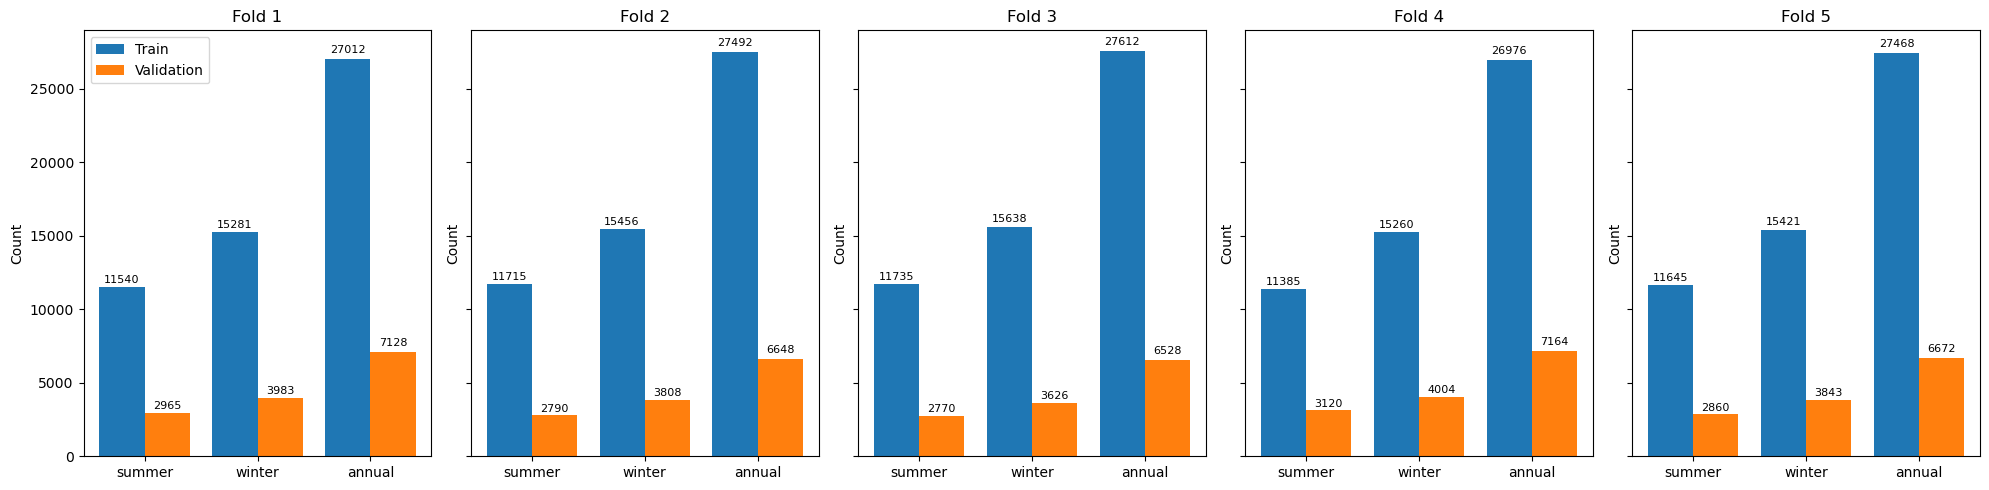

In [24]:
plot_train_val_counts(df_train_X, splits_s)

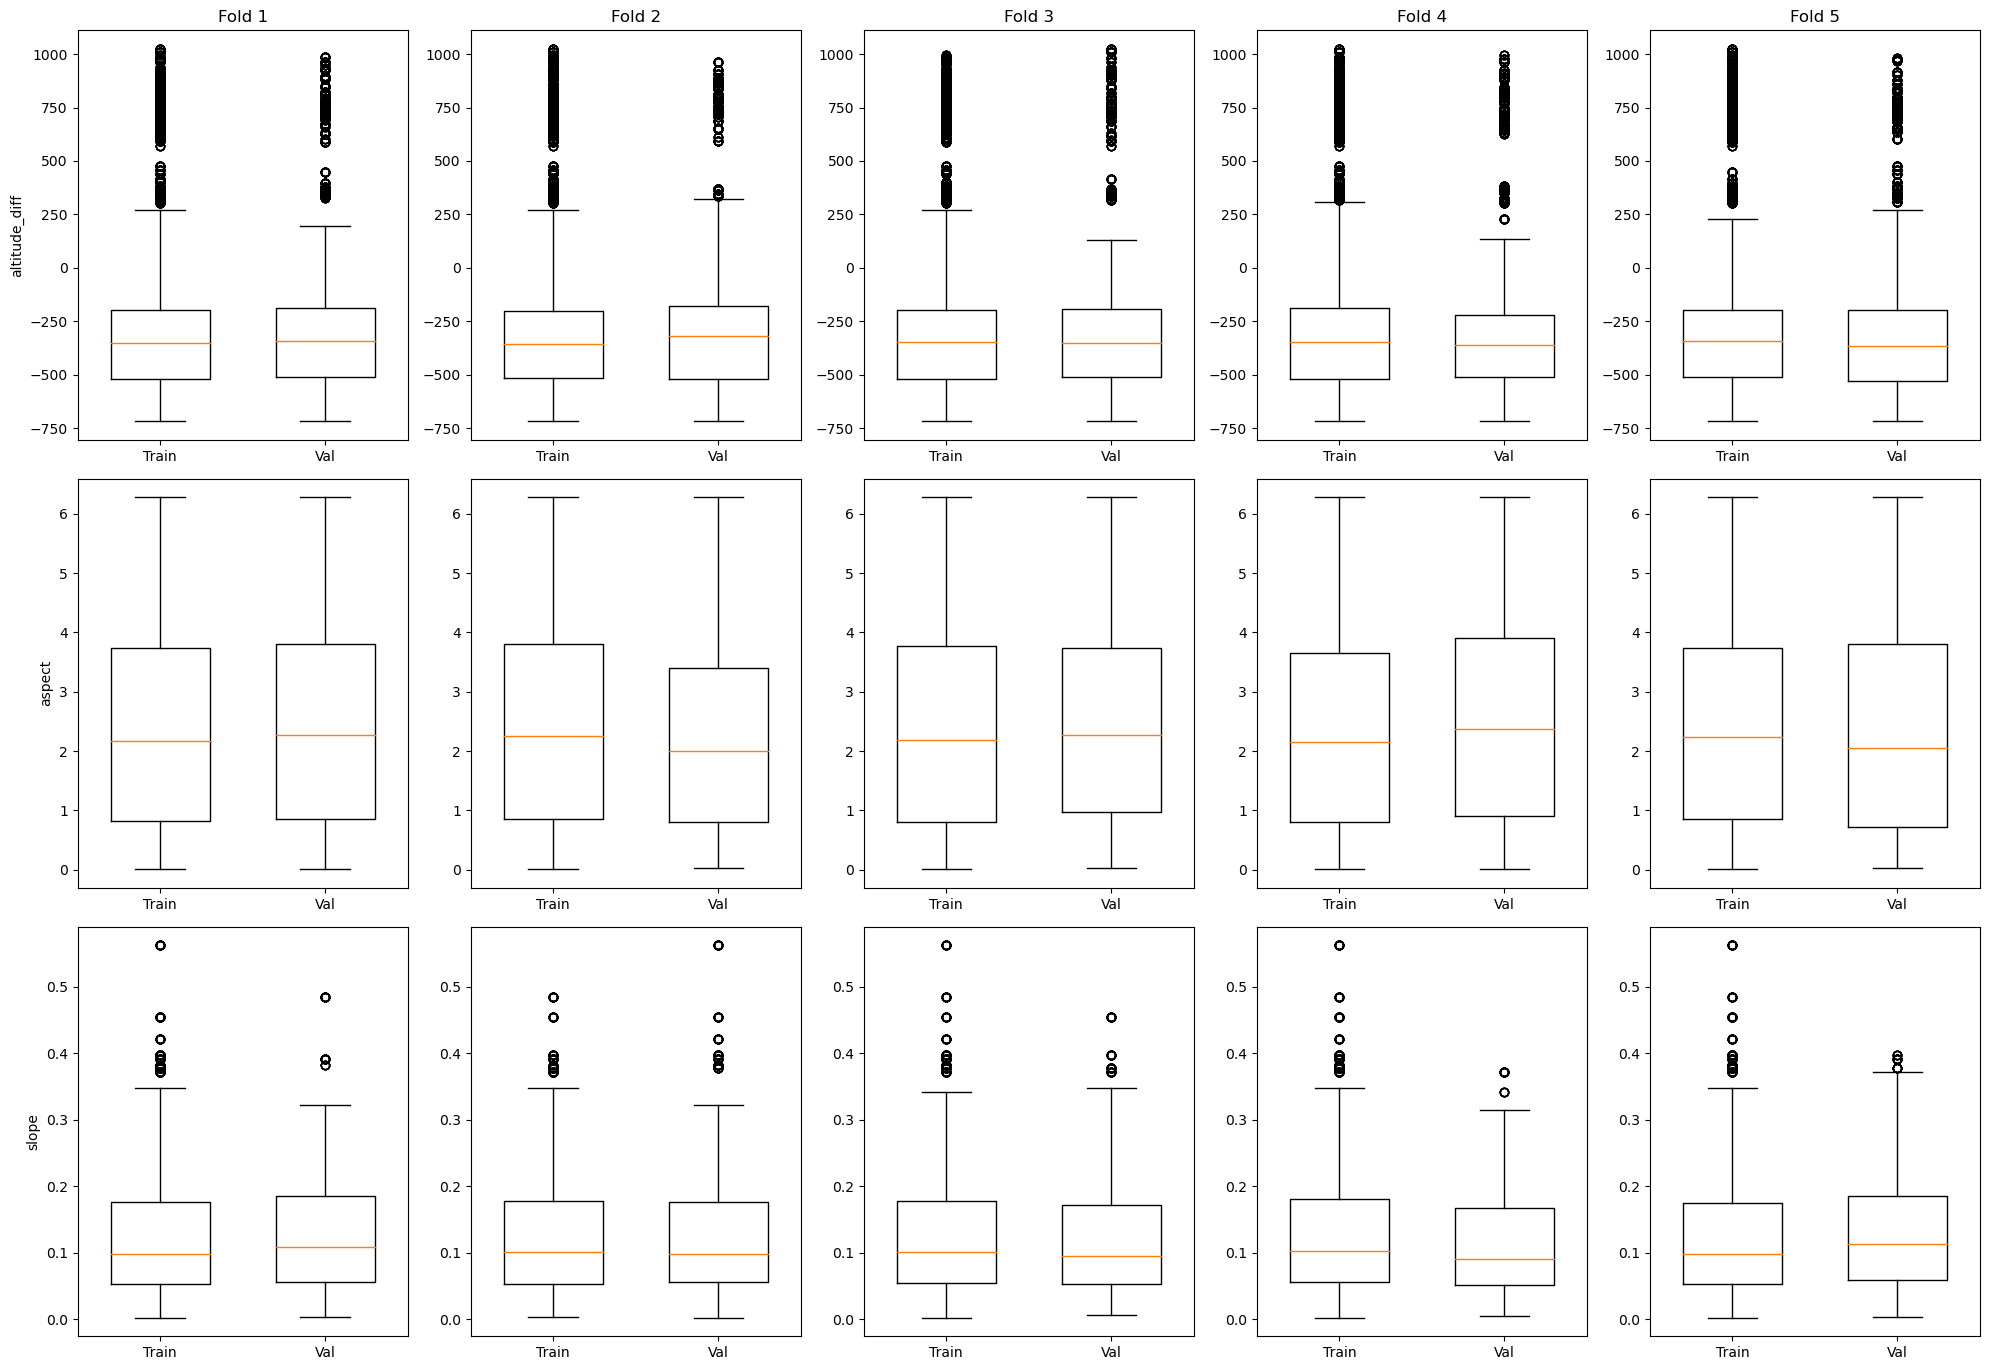

In [25]:
# Plot distribution of topographical features
feature_names_topo = ['altitude_diff', 'aspect', 'slope']

plot_feature_distributions(df_train_X, feature_names_topo, type='train', folds=5, splits_s=splits_s)

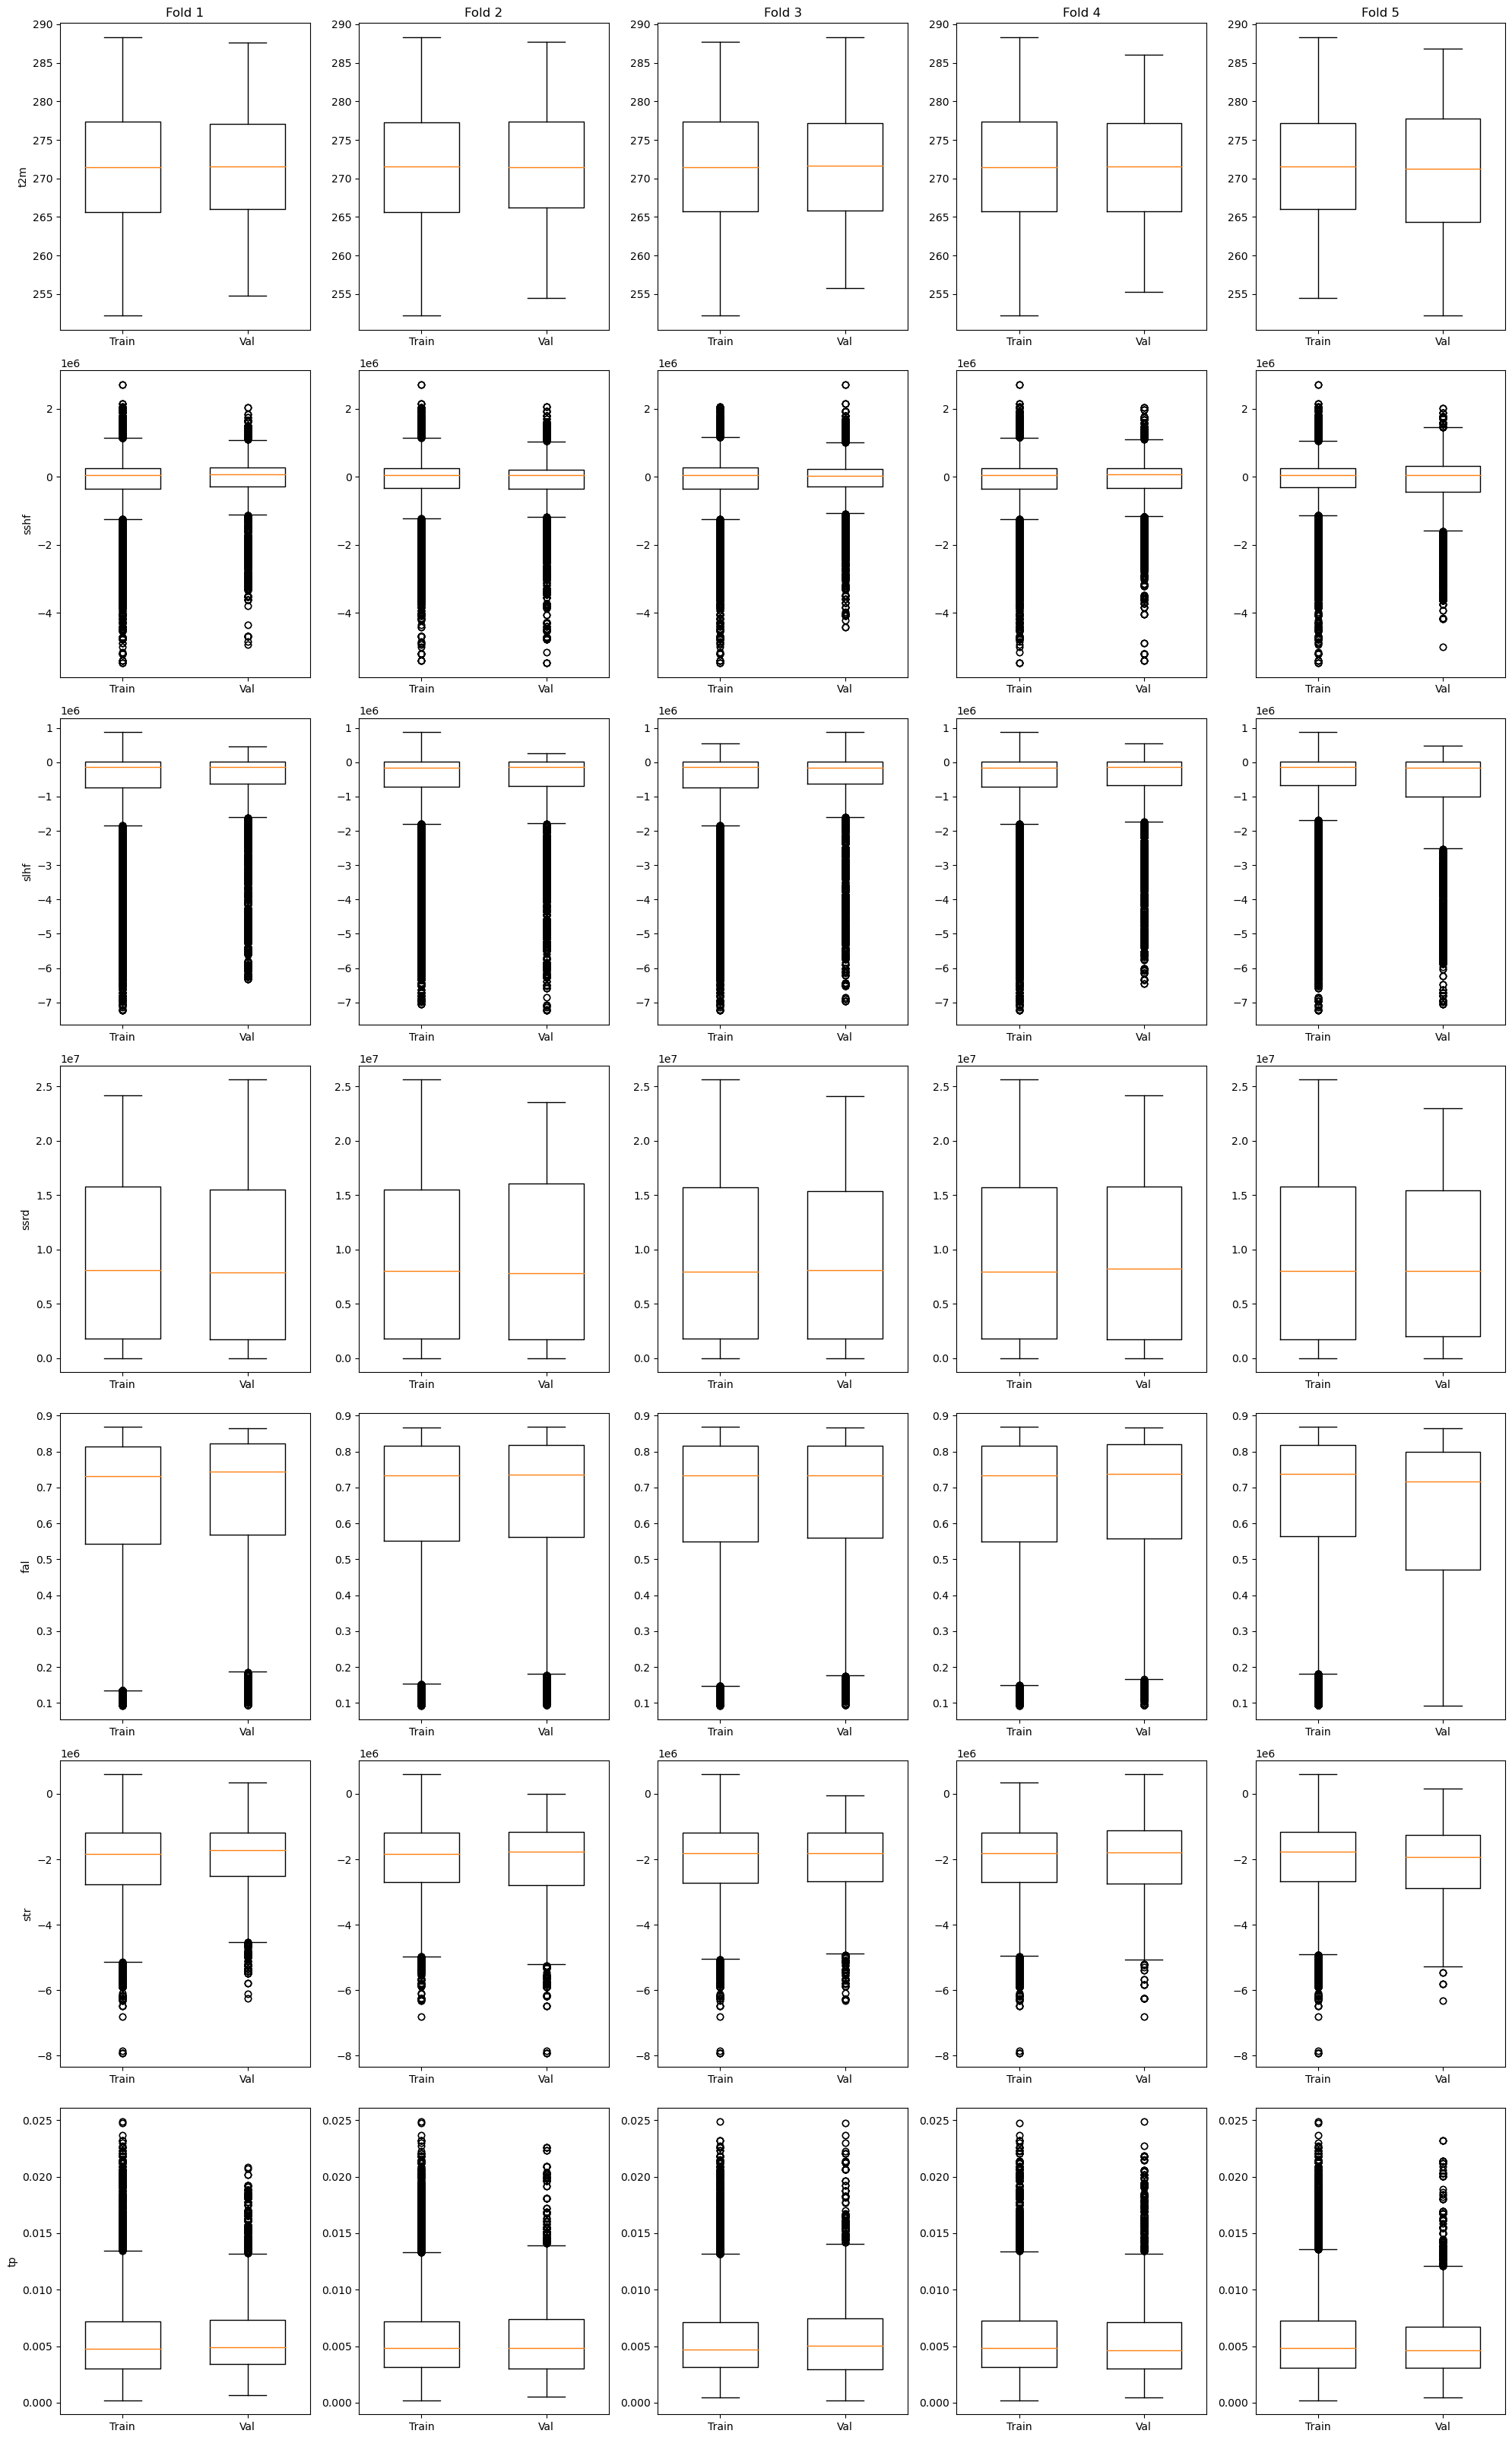

In [26]:
# Plot distribution of climate features
feature_names_climate = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal', 'str', 'tp']

plot_feature_distributions(df_train_X, feature_names_climate, type='train', folds=5, splits_s=splits_s)

## 3 Finalize test dataset

In [27]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
#X_test_unnorm, y_test = df_test_X.values, df_test_y.values
X_test, y_test = df_test_X.values, df_test_y.values

In [28]:
df_test_X

altitude_diff    aspect     slope  skyview_factor         t2m  \
0        -129.772081  0.629597  0.278773        0.778997  277.677979   
1        -129.772081  0.629597  0.278773        0.778997  283.339630   
2        -129.772081  0.629597  0.278773        0.778997  283.829285   
3        -129.772081  0.629597  0.278773        0.778997  283.778412   
4        -129.772081  0.629597  0.278773        0.778997  280.982513   
...              ...       ...       ...             ...         ...   
24908    -160.580241  2.906044  0.131717        0.932281  277.690887   
24909    -160.580241  2.906044  0.131717        0.932281  280.319031   
24910    -160.580241  2.906044  0.131717        0.932281  282.416504   
24911    -160.580241  2.906044  0.131717        0.932281  281.939026   
24912    -160.580241  2.906044  0.131717        0.932281  280.775269   

               sshf       slhf        ssrd       fal         str        tp  \
0      4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50  0.001159   
1     -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00  0.003054   
2     -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00  0.003977   
3     -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50  0.004691   
4      9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50  0.001449   
...             ...        ...         ...       ...         ...       ...   
24908 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25  0.003567   
24909  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00  0.008162   
24910 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25  0.007537   
24911 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00  0.007390   
24912 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00  0.006440   

         id  n_months month  
0         0         5   may  
1         0         5   jun  
2         0         5   jul  
3         0         5   aug  
4         0         5   sep  
...     ...       ...   ...  
24908  3092        12   may  
24909  3092        12   jun  
24910  3092        12   jul  
24911  3092        12   aug  
24912  3092        12   sep  

[24913 rows x 14 columns]

In [29]:
# Normalize features
# Using min-max scaling of training data

# Extract metadata columns
#metadata_columns_test = X_test_unnorm[:, -3:]

# Extract remaining columns
#remaining_columns_test = X_test_unnorm[:, :-3]

# Apply MinMaxScaler to the remaining columns
#scaled_remaining_columns_test = scaler.transform(remaining_columns_test)

# Combine scaled columns with metadata columns
#X_test = np.hstack((scaled_remaining_columns_test, metadata_columns_test))

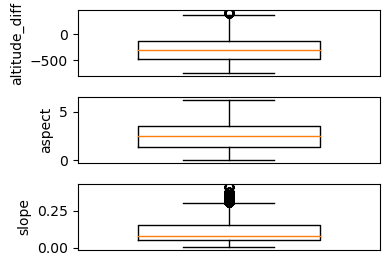

In [31]:
# Visualize test distributions
plot_feature_distributions(df_test_X, feature_names_topo, type='test', folds=1, splits_s=None)

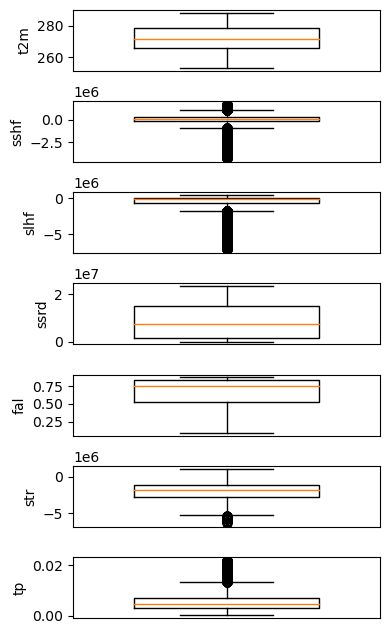

In [32]:
# Visualize test distributions
plot_feature_distributions(df_test_X, feature_names_climate, type='test', folds=1, splits_s=None)

## 4 Define helper functions

In [36]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [37]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

## 5 Model training

### 5.0 Test custom_mse_scorer with GridSearchCV on smaller version of dataset

In [163]:
# Set up dataset with random sample from annual, winter, summer

# Get random sample of annual, summer, winter
df_train_annual_sample = df_train_annual_clean.sample(n=1000, random_state=42)
df_train_summer_sample = df_train_summer_clean.sample(n=1000, random_state=42)
df_train_winter_sample = df_train_winter_clean.sample(n=1000, random_state=42)

# Reshape dataframes to monthly resolution
df_train_summer_sample_final = reshape_dataset_monthly(df_train_summer_sample, id_vars, variables, summer_months_order)
df_train_winter_sample_final = reshape_dataset_monthly(df_train_winter_sample, id_vars, variables, winter_months_order)
df_train_annual_sample_final = reshape_dataset_monthly(df_train_annual_sample, id_vars, variables, annual_months_order)

# Combine training data in one dataframe
df_train_summer_sample_final.reset_index(drop=True, inplace=True)
df_train_winter_sample_final.reset_index(drop=True, inplace=True)
df_train_annual_sample_final.reset_index(drop=True, inplace=True)

data_list = [df_train_summer_sample_final, df_train_winter_sample_final, df_train_annual_sample_final]
df_train_sample_final = pd.concat(data_list)
df_train_sample_final


id  BREID  year  altitude_diff  balance    aspect     slope  \
0         0    596  1963      11.181943    -3.41  2.509464  0.238202   
1         0    596  1963      11.181943    -3.41  2.509464  0.238202   
2         0    596  1963      11.181943    -3.41  2.509464  0.238202   
3         0    596  1963      11.181943    -3.41  2.509464  0.238202   
4         0    596  1963      11.181943    -3.41  2.509464  0.238202   
...     ...    ...   ...            ...      ...       ...       ...   
11995  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
11996  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
11997  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
11998  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   
11999  8497   3129  1967    -592.166788     1.58  2.526225  0.068208   

       n_months month         t2m          sshf       slhf        ssrd  \
0             5   may  274.658875  1.493194e+04  -375995.0  18766128.0   
1             5   jun  274.336243 -1.636112e+05  -521774.5  21166500.0   
2             5   jul  277.882172 -1.717710e+06 -2857569.5  15175713.0   
3             5   aug  281.432678 -1.826724e+06 -3644167.5  11799862.0   
4             5   sep  276.588593 -4.764911e+05 -1239184.5   6023235.0   
...         ...   ...         ...           ...        ...         ...   
11995        12   may  274.327118 -9.279995e+05  -247320.5  17505508.0   
11996        12   jun  277.050171 -8.421614e+05   101172.0  20268490.0   
11997        12   jul  278.294403 -4.923712e+05   282694.5  15490057.0   
11998        12   aug  280.939240 -1.117702e+06 -2140415.0  12475600.0   
11999        12   sep  280.146698 -9.786440e+05 -2591796.0   8269476.0   

            fal         str        tp  
0      0.596335 -2832247.00  0.001702  
1      0.613368 -2748427.50  0.001953  
2      0.282537 -3019285.50  0.004025  
3      0.123184 -4122848.50  0.002591  
4      0.295263 -2144487.50  0.006047  
...         ...         ...       ...  
11995  0.618479 -2179443.00  0.004908  
11996  0.551025 -2504472.50  0.007480  
11997  0.481296  -862670.75  0.006605  
11998  0.284415 -2001555.00  0.006391  
11999  0.119172 -3330040.00  0.005946  

[24000 rows x 16 columns]

In [112]:
# USING GROUP K-FOLD TO SPLIT ON ID

# Select features for training
df_train_X_reduce = df_train_sample_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X_sample = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y_sample = df_train_sample_final[['balance']]

# Get arrays of features+metadata and targets
X_train_s, y_train_s = df_train_X_sample.values, df_train_y_sample.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s_s = np.array(df_train_sample_final['id'].values)

# Use five folds
group_kf_s = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s_s = list(group_kf_s.split(X_train_s, y_train_s, gp_s_s))

print(len(gp_s_s))
print(y_train_s.shape)
print(X_train_s.shape)
print(df_train_X_sample.columns)
print(df_train_y_sample.columns)

# Check fold indices for training/validation data
fold_indices = []

for train_index, val_index in group_kf_s.split(X_train_s, y_train_s, gp_s_s):
    #print("TRAIN:", train_index, "VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "test:", val_index.shape)
    fold_indices.append((train_index, val_index))


4800
(4800, 1)
(4800, 13)
Index(['altitude_diff', 'aspect', 'slope', 't2m', 'sshf', 'slhf', 'ssrd',
       'fal', 'str', 'tp', 'id', 'n_months', 'month'],
      dtype='object')
Index(['balance'], dtype='object')


In [166]:
# USING GROUP K-FOLD TO SPLIT ON ID

# Select features for training
df_train_X_reduce = df_train_sample_final.drop(['balance','year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X_sample = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for training
df_train_y_sample = df_train_sample_final[['balance']]

# Get arrays of features+metadata and targets
X_train_s, y_train_s = df_train_X_sample.values, df_train_y_sample.values

# Define the year intervals for the folds
year_intervals = [
    (1960, 1969),  # Fold 1
    (1970, 1979),  # Fold 2
    (1980, 1994),  # Fold 3
    (1995, 2009),  # Fold 4
    (2010, 2021)   # Fold 5
]

# Add a 'fold' column based on the 'year' intervals
def assign_fold(row):
    for i, (start_year, end_year) in enumerate(year_intervals):
        if start_year <= row['year'] <= end_year:
            return i
    return -1  # Return -1 if year is not in any interval (should not happen)

df_train_sample_final['fold'] = df_train_sample_final.apply(assign_fold, axis=1)

# Verify that all rows have been assigned a valid fold
if (df_train_sample_final['fold'] == -1).any():
    raise ValueError("Some rows have not been assigned a valid fold")

# Group by 'id' to maintain groups of rows with the same 'id'
grouped = df_train_sample_final.groupby('id')

# Create indices for each fold
folds = [([], []) for _ in range(5)]  # Initialize with 5 empty train/test index lists

# Distribute groups into folds
for _, group in grouped:
    fold = group['fold'].iloc[0]  # All rows in group have the same fold
    for fold_idx in range(5):
        if fold == fold_idx:
            folds[fold_idx][1].extend(group.index)  # Assign group to test set of this fold
        else:
            folds[fold_idx][0].extend(group.index)  # Assign group to train set of other folds

# Convert lists to numpy arrays
folds = [(np.array(train_indices), np.array(test_indices)) for train_indices, test_indices in folds]

# Define the custom cross-validator
class CustomFoldIterator(BaseCrossValidator):
    def __init__(self, fold_indices):
        self.fold_indices = fold_indices

    def split(self, X, y=None, groups=None):
        for train_indices, test_indices in self.fold_indices:
            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.fold_indices)

# Setup and Execute GridSearchCV
custom_cv_s = CustomFoldIterator(folds)

# Create splits
splits_s_s = list(custom_cv_s.split(X_train_s, y_train_s))

# Convert Int64Index to numpy arrays 
splits_s_s = [(np.array(train_indices), np.array(test_indices)) for (train_indices, test_indices) in splits_s_s]

# Print number of instances in each split
for i, (train_indices, test_indices) in enumerate(splits_s_s):
    print(f"Fold {i+1} - Train: {len(train_indices)}, Test: {len(test_indices)}")

# Check fold indices for training/validation data
fold_indices = []

for i, (train_index, val_index) in enumerate(splits_s_s):
    print(f"Fold {i+1}")
    print("TRAIN:", train_index)
    print("VALIDATION:", val_index)
    print("shape(train):", train_index.shape, "shape(validation):", val_index.shape)
    fold_indices.append((train_index, val_index))

Fold 1 - Train: 16183, Test: 7817
Fold 2 - Train: 18369, Test: 5631
Fold 3 - Train: 21464, Test: 2536
Fold 4 - Train: 19019, Test: 4981
Fold 5 - Train: 20965, Test: 3035
Fold 1
TRAIN: [  195   196   197 ... 11877 11878 11879]
VALIDATION: [    0     1     2 ... 11997 11998 11999]
shape(train): (16183,) shape(validation): (7817,)
Fold 2
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  645   646   647 ... 11589 11590 11591]
shape(train): (18369,) shape(validation): (5631,)
Fold 3
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  195   196   197 ... 10401 10402 10403]
shape(train): (21464,) shape(validation): (2536,)
Fold 4
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  320   321   322 ... 11865 11866 11867]
shape(train): (19019,) shape(validation): (4981,)
Fold 5
TRAIN: [    0     1     2 ... 11997 11998 11999]
VALIDATION: [  640   641   642 ... 11877 11878 11879]
shape(train): (20965,) shape(validation): (3035,)


In [173]:
df_train_X_sample

altitude_diff    aspect     slope         t2m          sshf       slhf  \
0          11.181943  2.509464  0.238202  274.658875  1.493194e+04  -375995.0   
1          11.181943  2.509464  0.238202  274.336243 -1.636112e+05  -521774.5   
2          11.181943  2.509464  0.238202  277.882172 -1.717710e+06 -2857569.5   
3          11.181943  2.509464  0.238202  281.432678 -1.826724e+06 -3644167.5   
4          11.181943  2.509464  0.238202  276.588593 -4.764911e+05 -1239184.5   
...              ...       ...       ...         ...           ...        ...   
11995    -592.166788  2.526225  0.068208  274.327118 -9.279995e+05  -247320.5   
11996    -592.166788  2.526225  0.068208  277.050171 -8.421614e+05   101172.0   
11997    -592.166788  2.526225  0.068208  278.294403 -4.923712e+05   282694.5   
11998    -592.166788  2.526225  0.068208  280.939240 -1.117702e+06 -2140415.0   
11999    -592.166788  2.526225  0.068208  280.146698 -9.786440e+05 -2591796.0   

             ssrd       fal         str        tp  fold    id  n_months month  
0      18766128.0  0.596335 -2832247.00  0.001702     0     0         5   may  
1      21166500.0  0.613368 -2748427.50  0.001953     0     0         5   jun  
2      15175713.0  0.282537 -3019285.50  0.004025     0     0         5   jul  
3      11799862.0  0.123184 -4122848.50  0.002591     0     0         5   aug  
4       6023235.0  0.295263 -2144487.50  0.006047     0     0         5   sep  
...           ...       ...         ...       ...   ...   ...       ...   ...  
11995  17505508.0  0.618479 -2179443.00  0.004908     0  8497        12   may  
11996  20268490.0  0.551025 -2504472.50  0.007480     0  8497        12   jun  
11997  15490057.0  0.481296  -862670.75  0.006605     0  8497        12   jul  
11998  12475600.0  0.284415 -2001555.00  0.006391     0  8497        12   aug  
11999   8269476.0  0.119172 -3330040.00  0.005946     0  8497        12   sep  

[24000 rows x 14 columns]

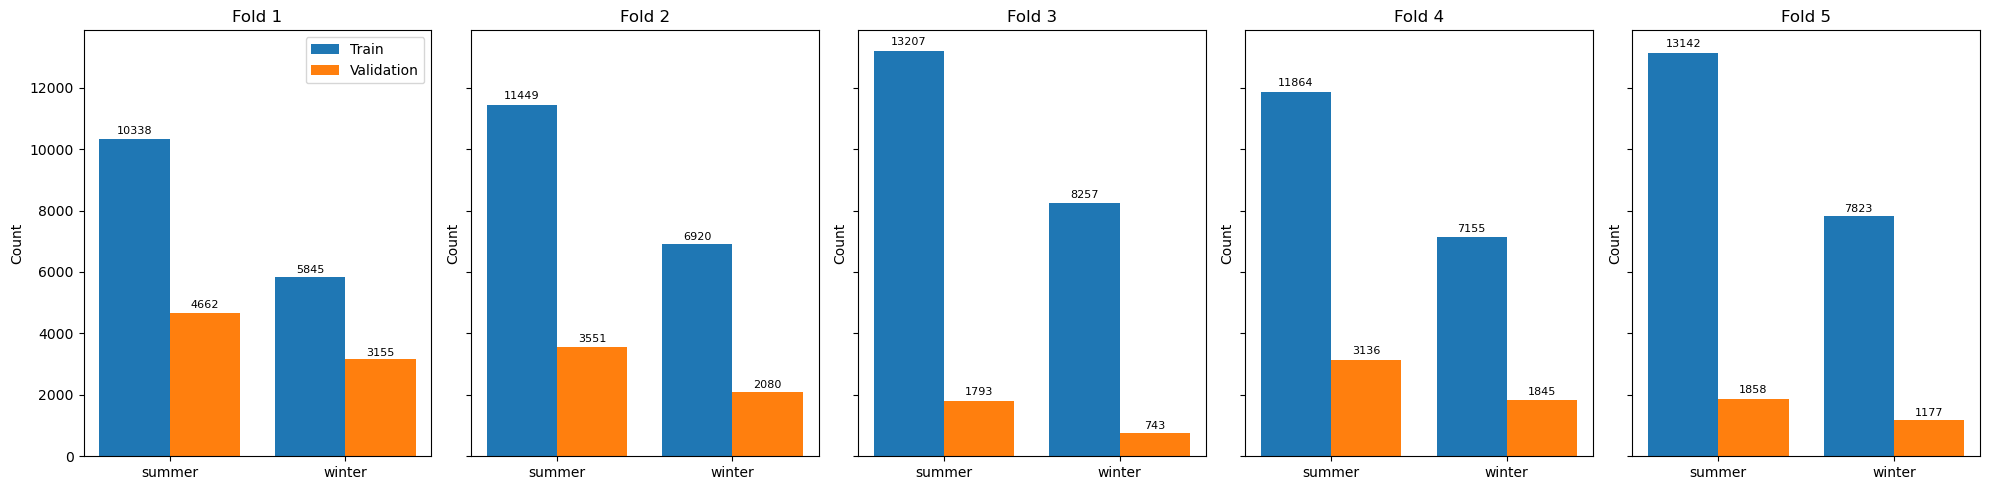

In [167]:
# Count number of annual and seasonal per fold

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Create a color map or list for the bars
colors = ['C0', 'C1']

n_months_to_season = {5: 'summer', 7: 'winter', 12: 'annual'}

for i, (train_index, val_index) in enumerate(splits_s_s):
    ax = axes[i]

    n_months_train = df_train_X_sample.iloc[train_index]['n_months']
    n_months_val = df_train_X_sample.iloc[val_index]['n_months']
    
    # Counts
    n_months_train_counts = dict(zip(*np.unique(n_months_train, return_counts=True)))
    n_months_val_counts = dict(zip(*np.unique(n_months_val, return_counts=True)))
    
    #n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    n_months_values = sorted(set(n_months_train_counts.keys()).union(n_months_val_counts.keys()))
    #print(n_months_values)
    season_names = [n_months_to_season[n_months] for n_months in n_months_values]

    train_positions = np.arange(len(n_months_values))
    val_positions = train_positions + 0.4 
    
    train_counts = [n_months_train_counts.get(x, 0) for x in n_months_values]
    ax.bar(train_positions, train_counts, width=0.4, label='Train', color=colors[0])
    
    val_counts = [n_months_val_counts.get(x, 0) for x in n_months_values]
    ax.bar(val_positions, val_counts, width=0.4, label='Validation', color=colors[1])

    # Annotate each bar with the respective count
    for j in range(len(n_months_values)):
        train_count = n_months_train_counts.get(n_months_values[j], 0)
        val_count = n_months_val_counts.get(n_months_values[j], 0)
        train_pos = train_positions[j]
        val_pos = val_positions[j]
        
        ax.text(train_pos, train_count + max(train_count, val_count) * 0.01, str(train_count),
                ha='center', va='bottom', fontsize=8, color='k')

        ax.text(val_pos, val_count + max(train_count, val_count) * 0.01, str(val_count),
                ha='center', va='bottom', fontsize=8, color='k')
    
    ax.set_title(f'Fold {i+1}')
    #ax.set_xlabel('n_months')
    ax.set_ylabel('Count')
    ax.set_xticks(train_positions + 0.2) 
    #ax.set_xticklabels(n_months_values)  
    ax.set_xticklabels(season_names)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [115]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5],#, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1],#, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'gamma':[0]#, 1, 10],
    }

xgb_model_s = CustomXGBRegressor()

clf = GridSearchCV(xgb_model_s, 
                   param_grid, 
                   cv=splits_s_s,
                   verbose=2, 
                   n_jobs=4, 
                   #scoring=custom_mse_scorer, 
                   scoring = None, # Uses default in CustomXGBRegressor()
                   refit=True, 
                   error_score='raise',
                   return_train_score=True) # Default False. If False, cv_results_ will not include training scores.

#X_features = X_train[:,:-3]

clf.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:32:22] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4785, 4786, 4787]),
                  array([  10,   11,   12,   13,   14,   35,   36,   37,   38,   39,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   85,   86,
         87,   88,   89,  120,  121,  122,  123,  124,  145,  146,  147,
        148,  149,  170,  171,  172,  173,  174,  195,  196,  197,  198,
        199,  220,  221,  222,  223,  224,  260,  261,  262,  263,  264,
        285,  286,  287,  288,  289,  335,  336,  337,  338,  339,  340,
        341,  342,  343,  344,  365,  366,  367,  368,  369,  375,  376,
        377,  378,...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:squarederror', ...),
             n_jobs=4,
             param_grid={'gamma': [0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300, 400]},
             return_train_score=True, verbose=2)

In [116]:
clf.cv_results_

{'mean_fit_time': array([ 2.61558394,  5.51799755,  8.54584718, 12.05234299,  2.99711914,
         5.83598604,  9.22830358, 13.75065036,  3.87030668,  7.37608309,
        11.18019438, 15.31760588,  3.65978427,  7.18985877, 10.59135833,
        13.94584832,  3.51128964,  7.03577757, 10.94791026, 15.75783353,
         3.64811478,  6.95111113, 12.09521241, 14.19531493]),
 'std_fit_time': array([0.04828631, 0.1070452 , 0.17380347, 0.1970568 , 0.10068233,
        0.07755495, 0.32981464, 0.62857951, 0.3427156 , 0.11067639,
        0.09483409, 0.35095483, 0.13218643, 0.09463175, 0.15108734,
        0.10427224, 0.04852474, 0.08707772, 0.55192382, 0.52178398,
        0.16297478, 0.16508729, 0.52088337, 1.91688058]),
 'mean_score_time': array([0.00837464, 0.00812197, 0.01034493, 0.01098919, 0.00856733,
        0.00974278, 0.01181026, 0.01694136, 0.01224427, 0.013064  ,
        0.01878195, 0.01918049, 0.00850897, 0.01386962, 0.00892634,
        0.01182995, 0.01018085, 0.01101847, 0.01339922, 0.01

In [117]:
clf.best_estimator_

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.01,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=400, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002178B824EE0>, ...)

In [118]:
# Save the model to a binary file
best_model = clf.best_estimator_

best_model.save_model('Models/Custom_loss/xgb_model_mini200_test_phl_200.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:14] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


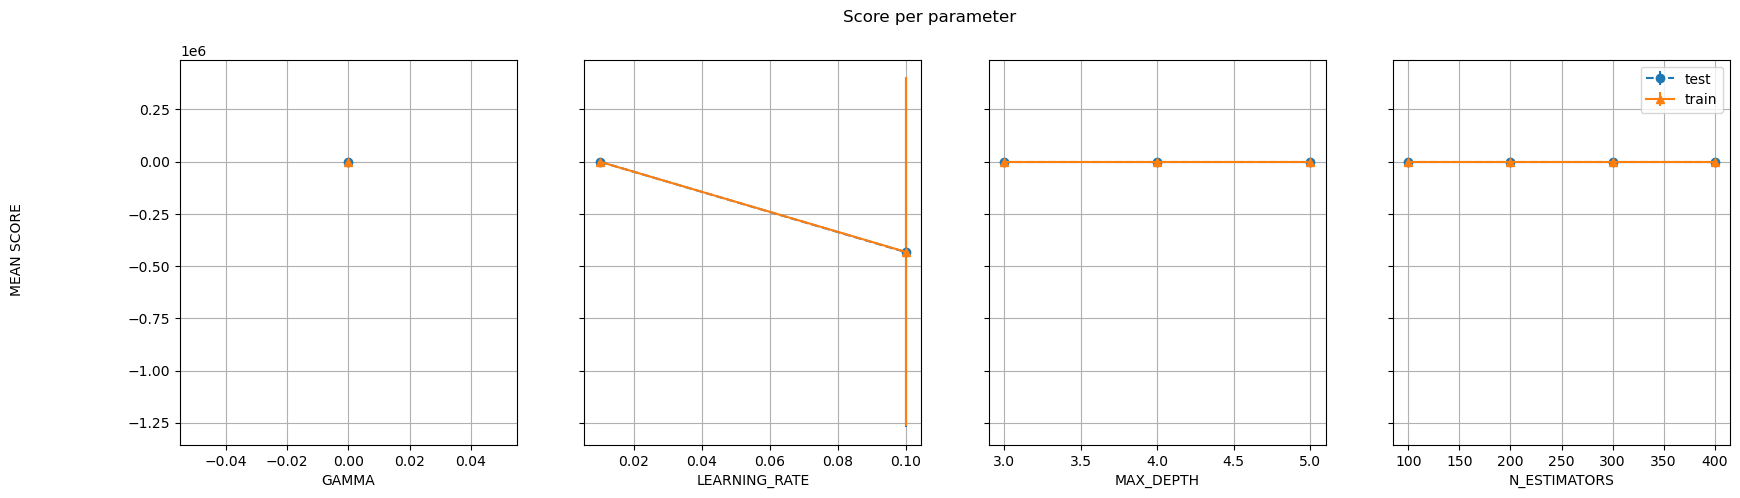

In [100]:
plot_gsearch_results(clf)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:28] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:38] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:34:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

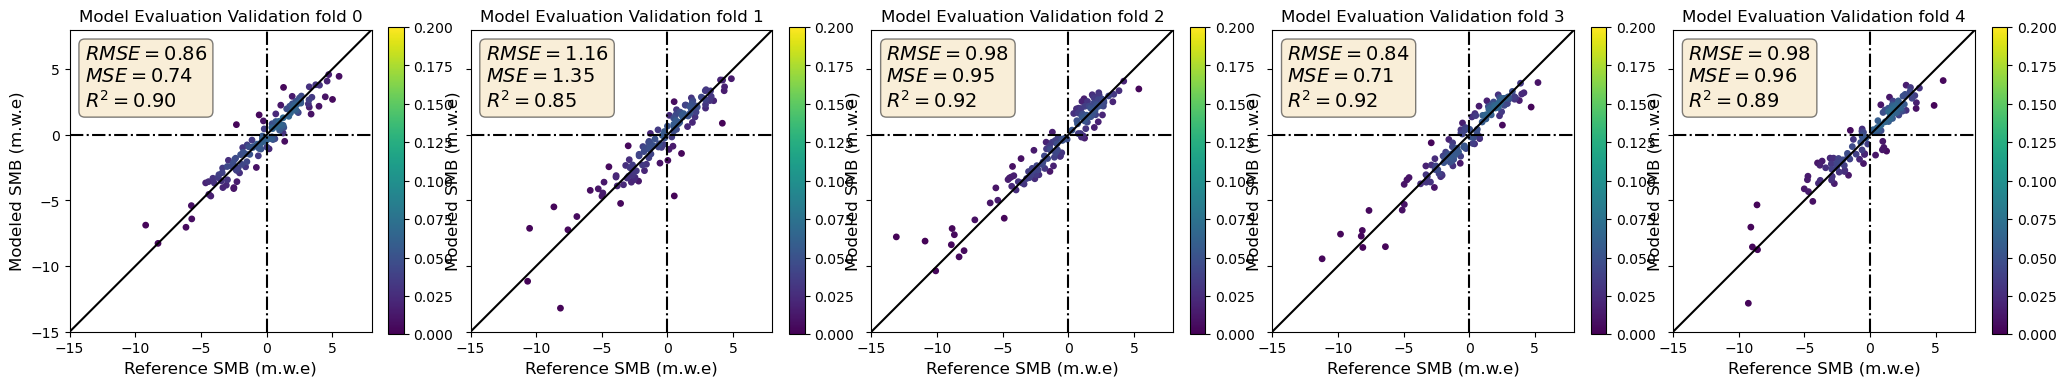

In [119]:
best_model = clf.best_estimator_

# Evaluate validation performance
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, val_index in splits_s_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_val_ = X_train_s[train_index], X_train_s[val_index]
    y_train_, y_val_ = y_train_s[train_index], y_train_s[val_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_val_)

    title = 'Validation fold ' + str(a)

    y_val_agg, y_pred_agg = get_ytrue_y_pred_agg(y_val_,y_pred,X_val_)

    plot_prediction_subplot(y_val_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1


In [141]:
print(y_val_agg)
print(y_pred_agg)
print(y_val_agg.shape)
print(y_pred_agg.shape)

[-2.35 -2.08 -3.04 -1.68 -0.59 -2.93 -1.69 -4.   -5.01 -4.69 -1.94 -4.77
 -3.93 -4.36 -2.9  -2.72 -2.39 -1.64 -2.29 -8.61 -9.08 -2.95 -1.92 -2.52
 -1.72  0.94  1.05 -0.41 -1.27 -0.8  -3.82 -1.06 -1.5  -2.55 -2.91 -2.89
 -1.96 -3.38 -3.65 -3.79  1.4   2.24  1.16  2.67  3.53 -0.18  3.2   2.16
  2.75  3.51  4.88  3.76  2.51  3.41  3.1   2.75  5.57  2.19  0.42  1.71
  1.55  1.72  2.35  3.08  3.05  1.46  2.05  1.48  1.86  1.7   1.75  1.87
  1.69  0.99  1.47  2.61  1.98  1.66  1.94  1.7   0.6   0.3  -2.4  -1.35
 -0.6  -0.32 -0.5  -0.5  -1.54 -0.61  1.57 -0.62 -2.95  0.97  0.85  0.54
  1.26 -9.27 -8.57  1.41  2.47 -8.96 -0.6   0.69  0.84  2.12  1.14 -0.71
 -0.53 -0.42  0.56  2.34  0.24  1.4   0.48 -0.62 -4.73  1.56  0.82 -2.78]
[-1.9080148e+00 -1.9088889e+00 -1.5458356e+00 -1.6578267e+00
 -6.4450949e-01 -3.3073556e+00 -1.2694535e+00 -2.3767269e+00
 -4.3284373e+00 -4.4091816e+00 -2.2678347e+00 -3.1172514e+00
 -3.4749699e+00 -4.0131598e+00 -2.7909584e+00 -2.8921592e+00
 -2.2012308e+00 -2.214572

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:21] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:42] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:35:53] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

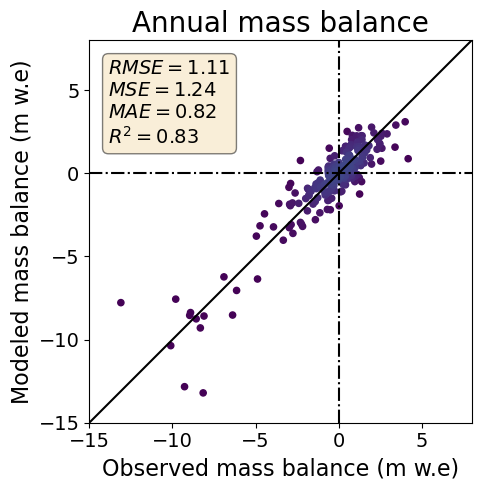

In [120]:
# Plot predictions vs. validation annual mass balance
y_val_annual, y_pred_annual = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=12)
y_val_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_val_annual, y_pred_annual, X_train_s, months=12)
plot_prediction_per_season(y_val_annual_mean, y_pred_annual_agg, season='Annual')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:26] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:36] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:47] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:36:58] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

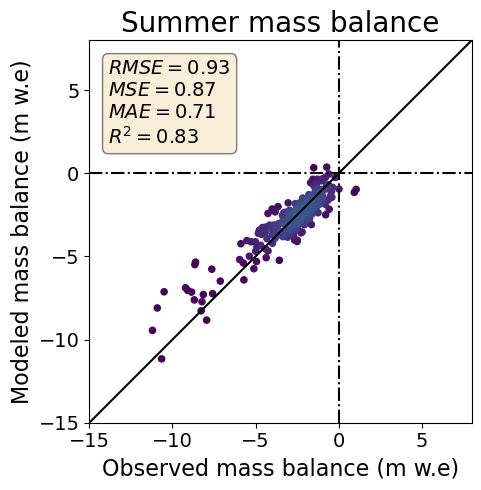

In [121]:
y_val_summer, y_pred_summer = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=5)
y_val_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_val_summer, y_pred_summer, X_train_s, months=5)
plot_prediction_per_season(y_val_summer_mean, y_pred_summer_agg, season='Summer')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:30] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:41] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:52] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [11:38:04] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata

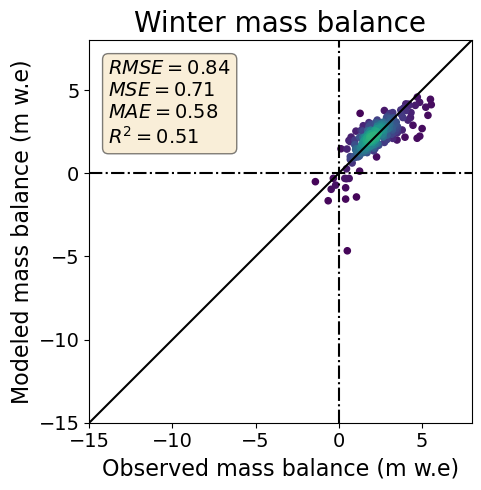

In [122]:
y_val_winter, y_pred_winter = get_prediction_per_season(X_train_s, y_train_s, splits_s_s, best_model, months=7)
y_val_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_val_winter, y_pred_winter, X_train_s, months=7)
plot_prediction_per_season(y_val_winter_mean, y_pred_winter_agg, season='Winter')

In [123]:
# Load trained model
xgb_model = CustomXGBRegressor()
xgb_model.load_model('Models/Custom_loss/xgb_model_mini200_test_phl_200.bin')

In [124]:
# TEST

y_pred_test = xgb_model.predict(X_test)

#plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [125]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

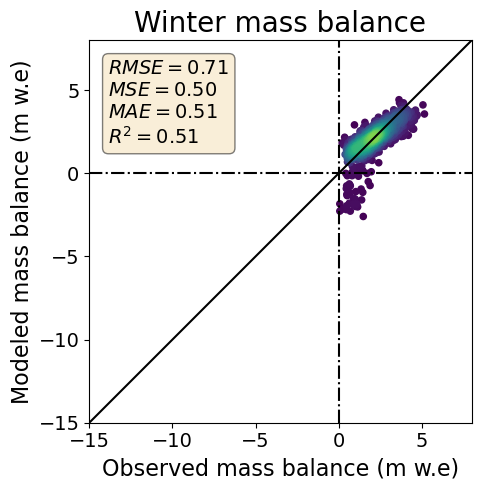

In [126]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, xgb_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

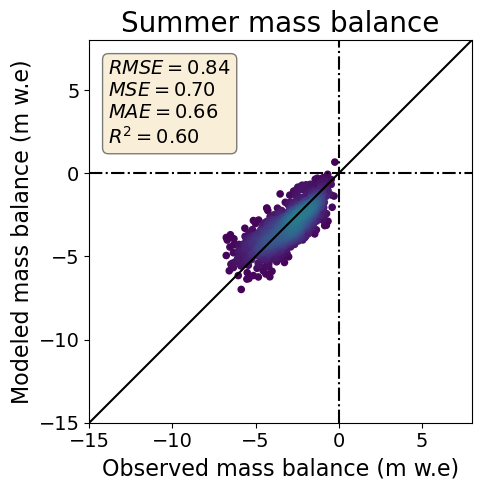

In [127]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, xgb_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

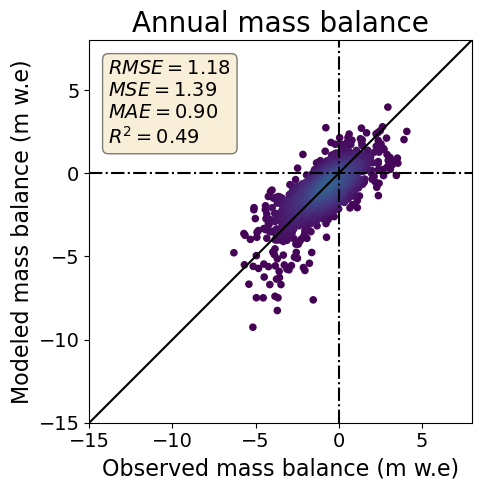

In [128]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, xgb_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

### 5.1 Model testing: Train model on one fold of full dataset 

In [44]:
# Select fold 0 as training data and fold 1 as validation data
X_train_crop = X_train[fold_indices[0][0],:]
X_val_crop = X_train[fold_indices[0][1],:]
y_train_crop = y_train[fold_indices[0][0]]
y_val_crop = y_train[fold_indices[0][1]]
#X_train_crop = X_train[fold_indices[1][0],:]
#X_val_crop = X_train[fold_indices[1][1],:]
#y_train_crop = y_train[fold_indices[1][0]]
#y_val_crop = y_train[fold_indices[1][1]]

# Check folds
print(X_train_crop.shape)
print(X_val_crop.shape)
print(y_train_crop.shape)
print(y_val_crop.shape)

(46079, 13)
(21830, 13)
(46079, 1)
(21830, 1)


In [37]:
# Define custom XGBRegressor object
xgb_model = CustomXGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, gamma=0)

# Fit model for fold 1
xgb_model.fit(X_train_crop, y_train_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:08:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=3, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=100, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001BE4E69D240>, ...)

In [67]:
# Save the model to a binary file
#xgb_model.save_model('Models/Custom_loss/xgb_model_fold1_test.bin')

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:26:32] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [20]:
# Load model
#loaded_model = CustomXGBRegressor()
#loaded_model.load_model('Models/Custom_loss/xgb_model_fold1_test.bin')

In [45]:
# Make predictions on the validation data
predictions = xgb_model.predict(X_val_crop)

In [46]:
# Get validation true values and predictions
y_true_mean, y_pred_agg = get_ytrue_y_pred_agg(y_val_crop,predictions,X_val_crop)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


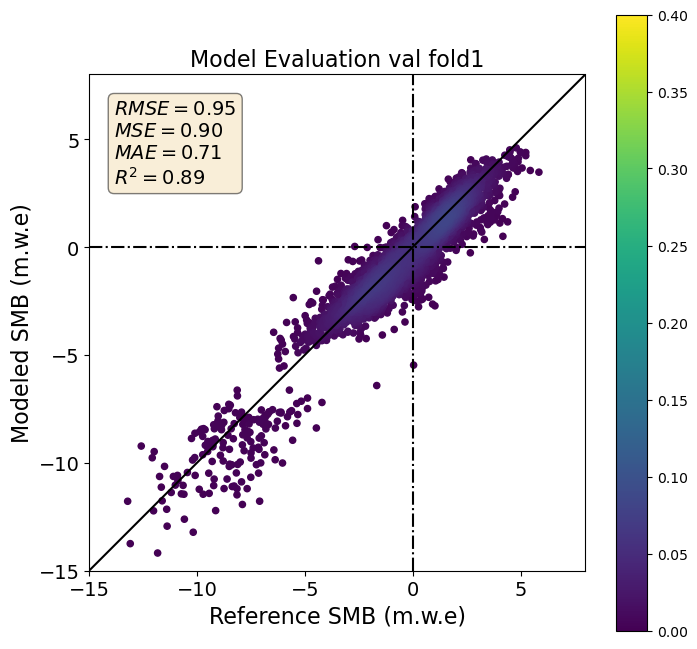

In [47]:
# Plot predictions vs true values for fold 1
plot_prediction(y_true_mean, y_pred_agg, data_type='val fold1')

### 5.2 Full model trained on cluster

In [38]:
# Load model
#loaded_model = CustomXGBRegressor()
#loaded_model.load_model('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')

# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
#with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
#param_ranges = {'max_depth': [5, 6, 7, 8], # Depth of tree
#                'n_estimators': [400, 500, 600, 700, 800], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15], #[0,1]
#                'gamma': [0, 10], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-07_13-11-48/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster forcing gamma=10
#param_ranges = {'max_depth': [5, 6, 7, 8], # Depth of tree
#                'n_estimators': [400, 500, 600, 700, 800], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2], #[0,1]
#                'gamma': [10], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-07_15-43-29/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster with custom pseudo-huber loss ## NOT WORKING, TOO HIGH LEARNING RATE!
#param_ranges = {'max_depth': [5, 6, 7, 8], # Depth of tree
#                'n_estimators': [400, 500, 600, 700, 800], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2], #[0,1]
#                'gamma': [0], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-08_12-41-40/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster with different gamma
#param_ranges = {'max_depth': [4, 5, 6, 7], # Depth of tree
#                'n_estimators': [100, 200, 300, 400], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2], #[0,1]
#                'gamma': [1, 5, 10], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-08_15-30-31/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster with different min child weight
#param_ranges = {'max_depth': [3, 4, 5, 6, 7], # Depth of tree
#                'n_estimators': [100, 200, 300, 400, 500], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.05, 0.1, 0.15], #[0,1]
#                'gamma': [0], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'min_child_weight': [0, 2, 4, 6, 8, 10], # [0,inf]
#                'random_state': [23]
#               } 
#with open('Training_cluster/2024-08-09_09-52-24/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on year intervals
#year_intervals = [
#    (1960, 1969),  # Fold 1
#    (1970, 1979),  # Fold 2
#    (1980, 1994),  # Fold 3
#    (1995, 2009),  # Fold 4
#    (2010, 2021)   # Fold 5
#]
#param_ranges = {'max_depth': [3, 4, 5, 6, 7], # Depth of tree
#                'n_estimators': [100, 200, 300, 400, 500], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.05, 0.1, 0.15, 0.2], #[0,1]
#                'gamma': [0], # Regularization parameter, minimum loss reduction required to make split [0,inf]
#                'min_child_weight': [0, 5, 10], # [0,inf]
#                'random_state': [23]             } 
#with open('Training_cluster/2024-08-10_15-38-58/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years
#with open('Training_cluster/2024-08-19_09-12-34/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL AND WINTER DATA
#with open('Training_cluster/2024-10-25_09-45-30/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL SEASONAL DATA ONLY
#with open('Training_cluster/2024-10-25_13-31-32/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL AND SUMMER DATA
#with open('Training_cluster/2024-10-25_15-05-53/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ONLY ANNUAL DATA
#with open('Training_cluster/2024-10-25_15-40-30/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ONLY WINTER DATA
#with open('Training_cluster/2024-10-25_16-09-23/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ONLY SUMMER DATA
#with open('Training_cluster/2024-10-25_16-37-13/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)


In [39]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001B8E6DAAD40>, ...)

In [39]:
# Load cv-results
#import joblib
#cv_grid = joblib.load('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')
#best_model = cv_grid.best_estimator_

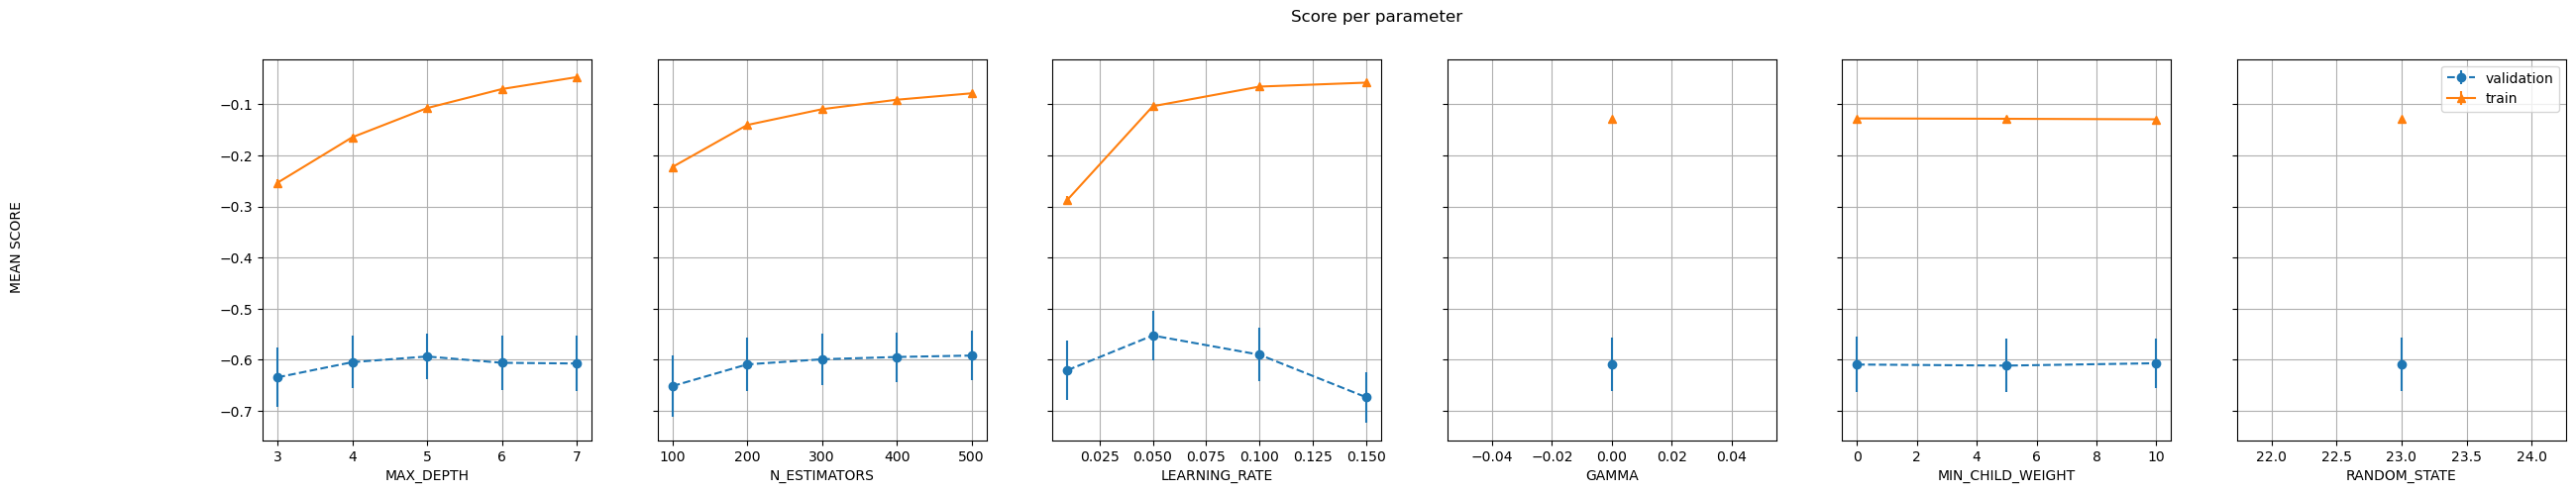

In [40]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.15)

In [41]:
# Assuming `grid_search_cv` is your GridSearchCV object
cv_results = clf_loaded.cv_results_

# Create a DataFrame with mean test scores and parameter settings
results_df = pd.DataFrame({
    'mean_test_score': cv_results['mean_test_score'],
    'params': cv_results['params']
})

# Sort the DataFrame by mean_test_score in ascending order
sorted_results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Get the 5 lowest mean test scores and corresponding parameter settings
lowest_5 = sorted_results_df.head(5)

# Display the results
print(lowest_5)

lowest_mean_test_scores = lowest_5['mean_test_score'].values
lowest_parameters = lowest_5['params'].values

print("5 Lowest Mean Test Scores:")
print(lowest_mean_test_scores)

print("\nCorresponding Parameter Settings:")
for params in lowest_parameters:
    print(params)



     mean_test_score                                             params
107        -0.519527  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
108        -0.521531  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
109        -0.522960  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
104        -0.524181  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
103        -0.524468  {'gamma': 0, 'learning_rate': 0.05, 'max_depth...
5 Lowest Mean Test Scores:
[-0.51952683 -0.52153061 -0.52295998 -0.52418137 -0.52446832]

Corresponding Parameter Settings:
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 300, 'random_state': 23}
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 400, 'random_state': 23}
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23}
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500,

In [42]:
# Assuming `grid_search_cv` is your GridSearchCV object
cv_results = clf_loaded.cv_results_

# Number of folds (assuming it's 5 here, but should match your actual number of folds)
num_folds = 5

# Create a DataFrame to hold results
results_df = pd.DataFrame(cv_results)

# Initialize a dictionary to hold the best parameter set for each fold
best_params_per_fold = {}

# Loop over each fold to find the best parameter set
for fold in range(num_folds):
    fold_col = f'split{fold}_test_score'
    
    # Get the index of the best score for the current fold
    best_index = results_df[fold_col].idxmax()
    
    # Get the corresponding parameter set
    best_params_per_fold[fold] = results_df.loc[best_index, 'params']

# Display the best parameter set for each fold
for fold, params in best_params_per_fold.items():
    print(f"Best parameters for fold {fold}: {params}")


Best parameters for fold 0: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23}
Best parameters for fold 1: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23}
Best parameters for fold 2: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 300, 'random_state': 23}
Best parameters for fold 3: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23}
Best parameters for fold 4: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23}


In [171]:
# Load separately because clf_loaded.best_estimator_ is refit using all data during 
# grid search and below the model is refit for each fold
fold_model = clf_loaded.best_estimator_
#fold_model = CustomXGBRegressor(max_depth=3, learning_rate=0.05, n_estimators=500, gamma=0, random_state=23, min_child_weight=10)

#fold_model = CustomXGBRegressor(max_depth=3, learning_rate=0.05, n_estimators=200, gamma=0, random_state=23, min_child_weight=0)

#fold_model = CustomXGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=100, gamma=0, random_state=23, min_child_weight=10)


C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:11:51] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:12:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:12:50] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:13:21] WARNING: D:\bld\xgboost-split_1705650032250\w

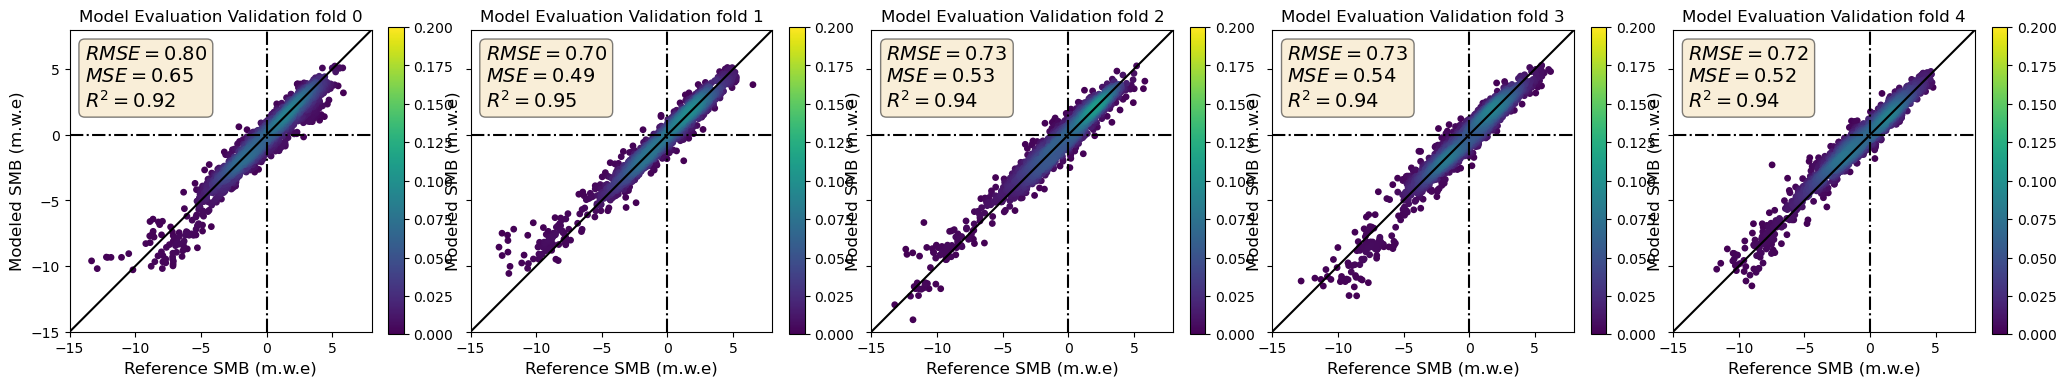

In [172]:
# Evaluate validation performance
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, val_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    y_train_, y_val_ = y_train[train_index], y_train[val_index]
    fold_model.fit(X_train_, y_train_)
    y_pred = fold_model.predict(X_val_)

    title = 'Validation fold ' + str(a)

    y_val_agg, y_pred_agg = get_ytrue_y_pred_agg(y_val_,y_pred,X_val_)

    plot_prediction_subplot(y_val_agg, y_pred_agg, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:15:23] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:16:11] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:16:49] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:17:26] WARNING: D:\bld\xgboost-split_1705650032250\w

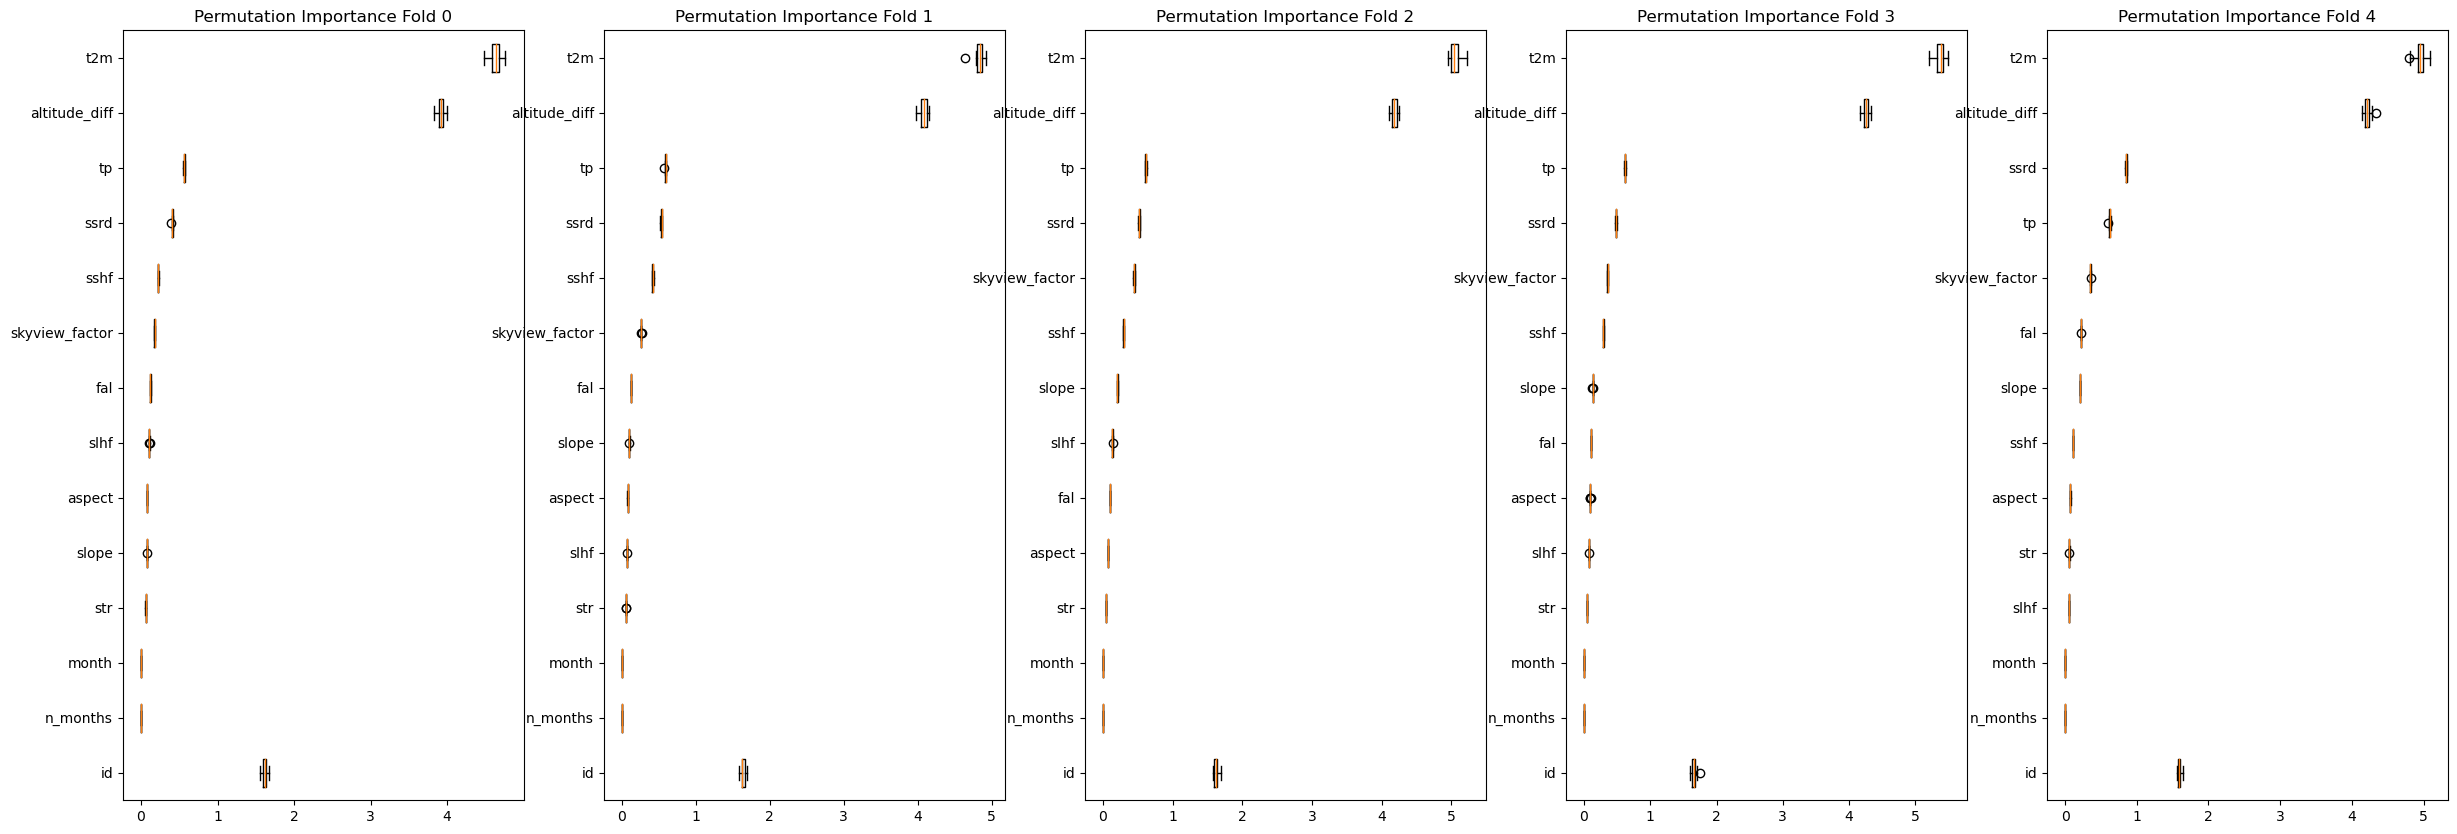

In [174]:
result = plot_permutation_importance_per_fold(df_train_X, X_train, y_train, splits_s, fold_model, max_features_plot = 15)

Text(0.5, 1.0, 'Feature Importance (MDI)')

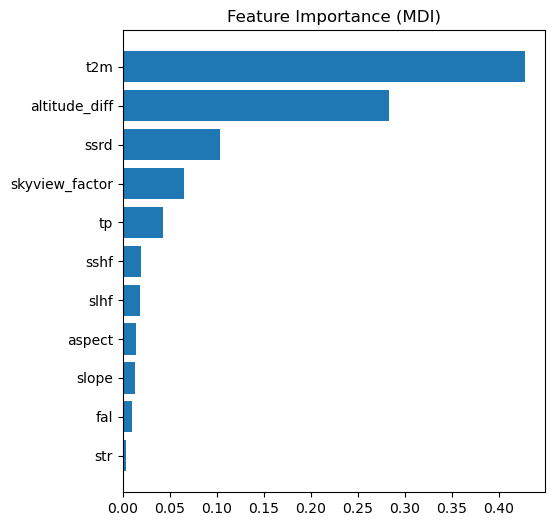

In [175]:
best_model = clf_loaded.best_estimator_

plot_feature_importance(best_model)

In [44]:
# Load best model refit to all training data
#best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=500, gamma=0, random_state=23, min_child_weight=0)
#best_model.fit(X_train, y_train)
best_model = clf_loaded.best_estimator_



In [45]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001B8E6DAAD40>, ...)

In [52]:
#best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=500, gamma=0, random_state=23, min_child_weight=0)
#seasonal_indices = X_train[:, -2] != 12
#X_train_seasonal = X_train[seasonal_indices]
#y_train_seasonal = y_train[seasonal_indices]

#best_model.fit(X_train_seasonal, y_train_seasonal)

In [54]:
#best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=500, gamma=0, random_state=23, min_child_weight=0)
#ann_win_indices = X_train[:, -2] != 5
#X_train_ann_win = X_train[ann_win_indices]
#y_train_ann_win = y_train[ann_win_indices]

#best_model.fit(X_train_ann_win, y_train_ann_win)

#print(X_train_ann_win.shape)
#print(y_train_ann_win.shape)

In [187]:
# Ensemble predictions using 5 best mean scores
#ALL DATA
#param_list=[{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 300, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 400, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 400, 'random_state': 23}]
# WINTER AND ANNUAL
#param_list = [{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 400, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 300, 'random_state': 23}]
# SEASONAL
#param_list = [{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 300, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 400, 'random_state': 23}]
# SUMMER AND ANNUAL
#param_list = [{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 400, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 400, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 300, 'random_state': 23}]

# Ensemble predictions using best score per fold
#ALL DATA
#param_list=[{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 300, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#            {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23}]
# WINTER AND ANNUAL
#param_list = [{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 200, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 400, 'random_state': 23}]
# SEASONAL
#param_list = [{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 200, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 23},
#              {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'random_state': 23}]
# SUMMER AND ANNUAL
param_list = [{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23},
              {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 500, 'random_state': 23},
              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 400, 'random_state': 23},
              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'random_state': 23},
              {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 23}]

y_test_pred_agg_all = []
y_pred_winter_agg_all = []
y_pred_summer_agg_all = []
y_pred_annual_agg_all = []

case = 'summer' # 'seasonal', 'summer', 'winter', 'annual', else all data

for params in param_list:
    #print(params)
    model = CustomXGBRegressor(max_depth=params['max_depth'], learning_rate=params['learning_rate'], n_estimators=params['n_estimators'], 
                               gamma=params['gamma'], random_state=params['random_state'], min_child_weight=params['min_child_weight'])

    if case == 'winter':
        case_indices = X_train[:, -2] != 5 # all but summer
        X_train_case = X_train[case_indices]
        y_train_case = y_train[case_indices]
    elif case == 'seasonal':
        case_indices = X_train[:, -2] != 12 # all but annual
        X_train_case = X_train[case_indices]
        y_train_case = y_train[case_indices]
    elif case == 'summer':
        case_indices = X_train[:, -2] != 7 # all but winter
        X_train_case = X_train[case_indices]
        y_train_case = y_train[case_indices]
    else:
        X_train_case = X_train.copy()
        y_train_case = y_train.copy()
    
    model.fit(X_train_case, y_train_case)
    test_pred = model.predict(X_test)

    _, y_test_pred_agg = get_ytrue_y_pred_agg(y_test, test_pred, X_test)

    y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, model, months=7)
    winter_indices = X_test[:, -2] == 7
    X_test_winter = X_test[winter_indices]
    _, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)

    y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, model, months=5)
    summer_indices = X_test[:, -2] == 5
    X_test_summer = X_test[summer_indices]
    _, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)

    y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, model, months=12)
    annual_indices = X_test[:, -2] == 12
    X_test_annual = X_test[annual_indices]
    _, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)

    y_test_pred_agg_all.append(y_test_pred_agg)
    y_pred_winter_agg_all.append(y_pred_winter_agg)
    y_pred_summer_agg_all.append(y_pred_summer_agg)
    y_pred_annual_agg_all.append(y_pred_annual_agg)
    

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:14] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:37:46] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:38:19] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [15:38:47] WARNING: D:\bld\xgboost-split_1705650032250\w

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


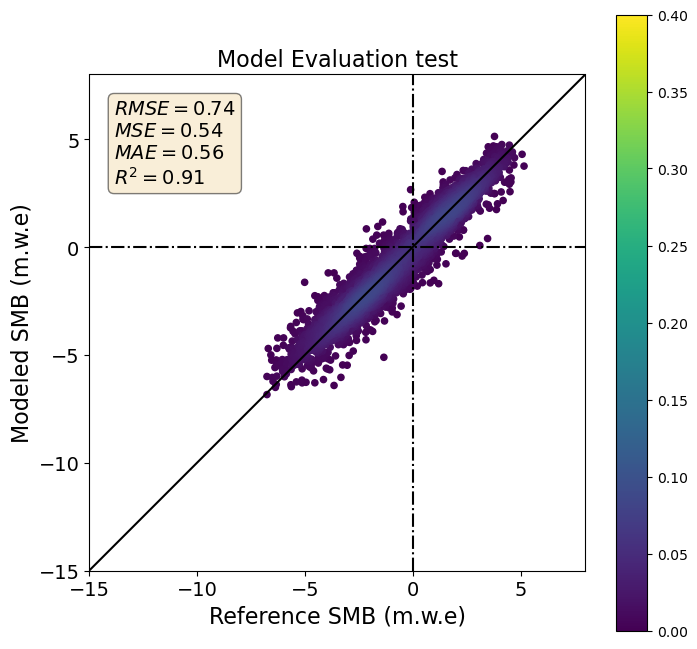

In [188]:
# Compute the mean of the arrays in each list
ensemble_y_test_pred_agg = np.mean(np.array(y_test_pred_agg_all), axis=0)

# Print the results for verification
plot_prediction(y_test_mean, ensemble_y_test_pred_agg, data_type='test')

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


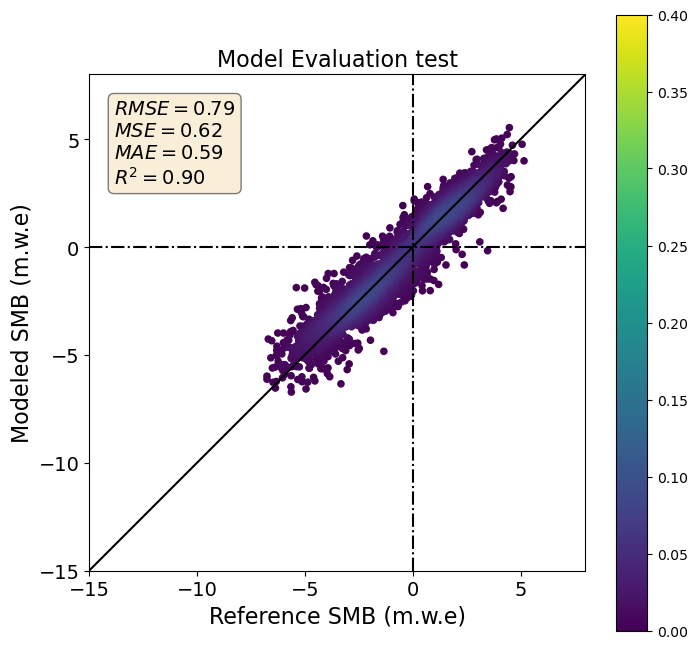

In [48]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

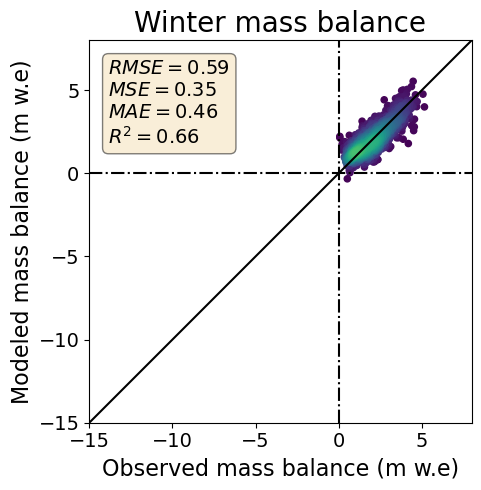

In [49]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

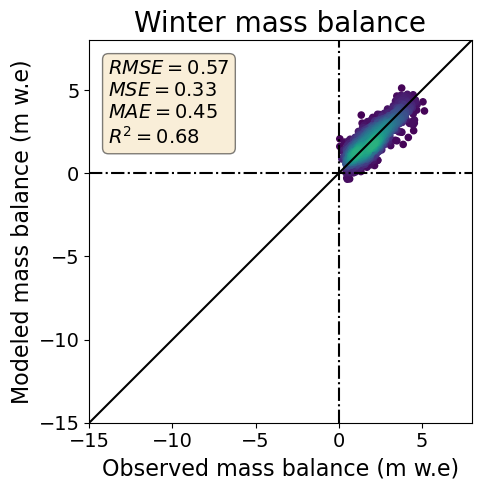

In [190]:
# Ensemble case winter
ensemble_y_pred_winter_agg = np.mean(np.array(y_pred_winter_agg_all), axis=0)
plot_prediction_per_season(y_test_winter_mean, ensemble_y_pred_winter_agg, season='Winter')

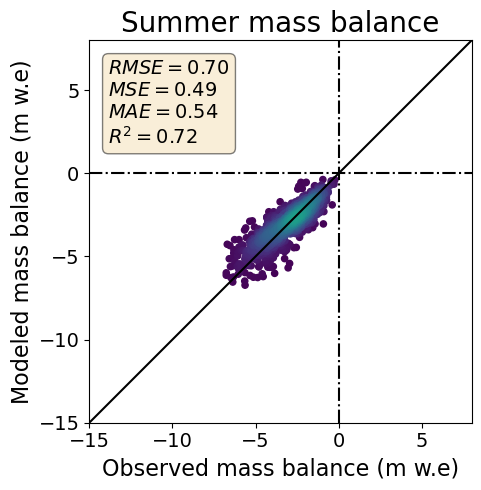

In [50]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

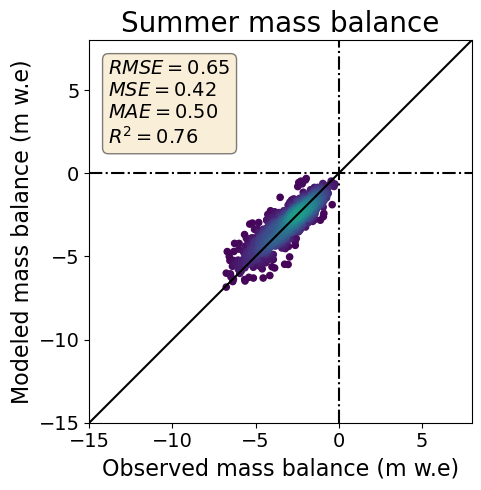

In [191]:
# Ensemble case summer
ensemble_y_pred_summer_agg = np.mean(np.array(y_pred_summer_agg_all), axis=0)
plot_prediction_per_season(y_test_summer_mean, ensemble_y_pred_summer_agg, season='Summer')

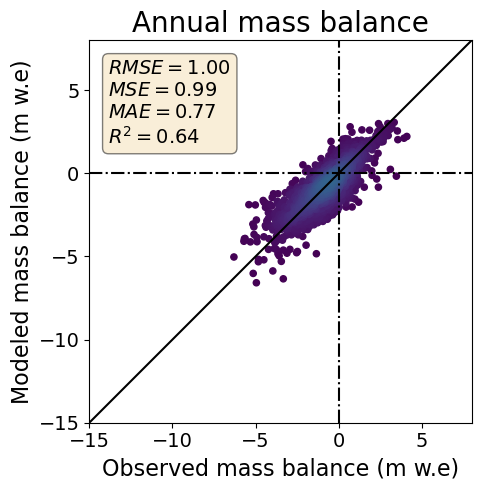

In [51]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

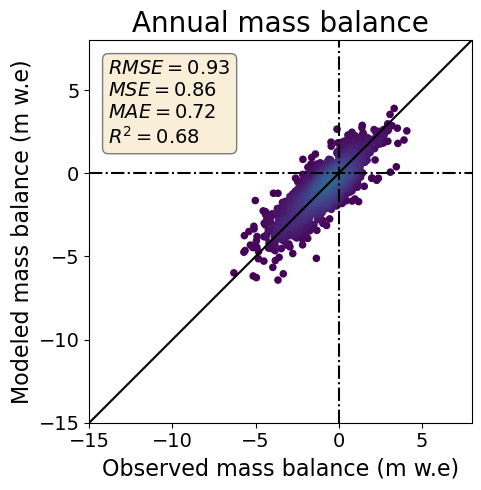

In [192]:
# Ensemble case annual
ensemble_y_pred_annual_agg = np.mean(np.array(y_pred_annual_agg_all), axis=0)
plot_prediction_per_season(y_test_annual_mean, ensemble_y_pred_annual_agg, season='Annual')

In [52]:
best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=500, gamma=0, random_state=23, min_child_weight=0)
best_model.fit(X_train, y_train)

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\xgboost\core.py:160: UserWarning: [16:51:03] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=500, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001B8E4361870>, ...)

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


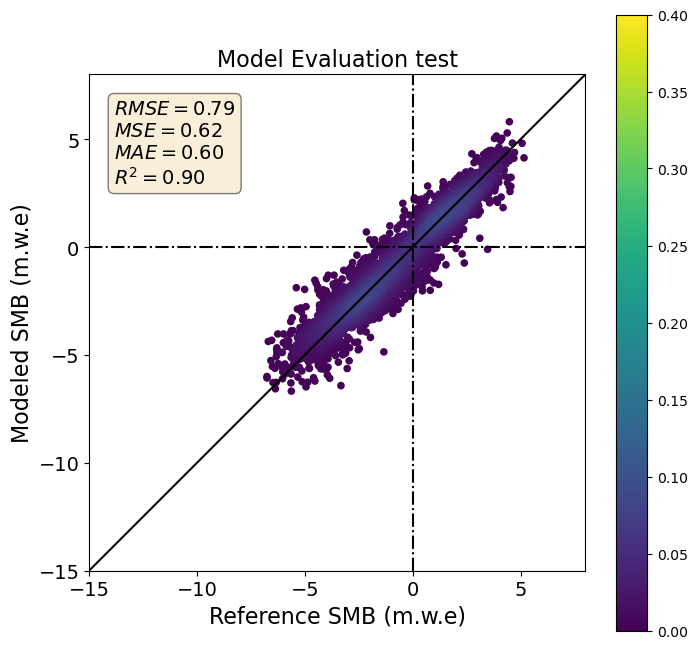

In [53]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

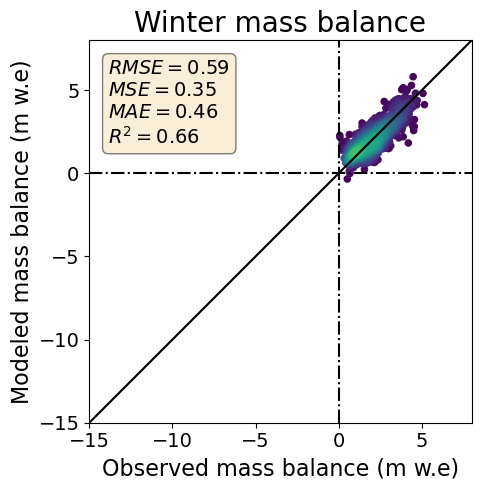

In [54]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

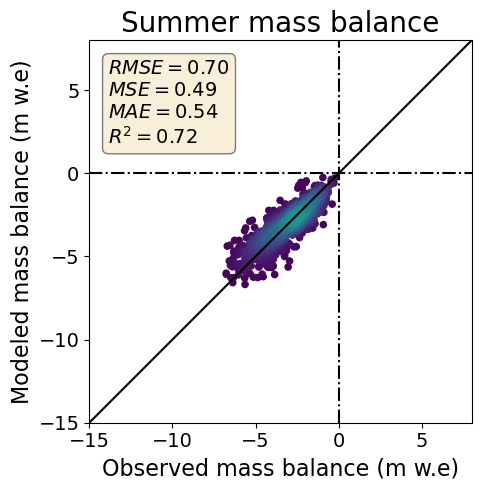

In [55]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

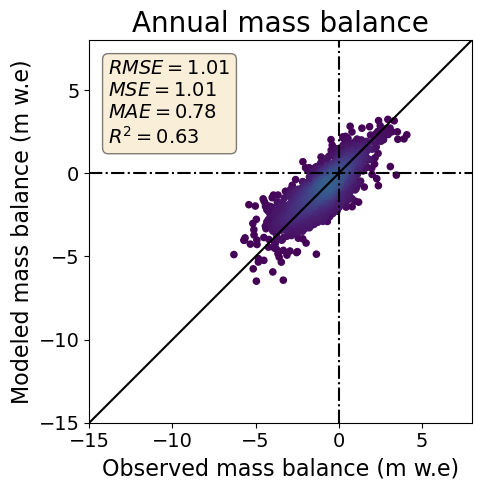

In [56]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

In [224]:
# Make predictions on annual mass balance using two models, one trained on winter and one trained on summer

# Need to extract annual data from X_test
# This is done in X_test_annual

# Duplicate annual data
X_test_only_winter = X_test_annual.copy()
X_test_only_summer = X_test_annual.copy()

# For winter, set n_months equal to 7. For summer, set n_months equal to 5
X_test_only_winter[:,-2] = 7
X_test_only_summer[:,-2] = 5

# Remove months not part of winter (
pattern_length = 12  # 5 selected + 7 skipped
select_rows = 7
n=X_test_only_winter.shape[0]

# Create the basic pattern mask
pattern_mask = np.array([True] * select_rows + [False] * (pattern_length - select_rows))

# Calculate how many times we need to repeat this pattern to cover the entire array
repeat_count = (n + pattern_length - 1) // pattern_length  # Ceil division

# Create the full mask
full_mask = np.tile(pattern_mask, repeat_count)[:n]

# Apply the mask to the array to select the desired rows
X_test_only_winter = X_test_only_winter[full_mask]

# Remove months not part of summer
pattern_length = 12  # 5 skipped + 7 selected
skip_rows = 7
select_rows = 5
n=X_test_only_summer.shape[0]

# Create the basic pattern mask
pattern_mask = np.array([False] * skip_rows + [True] * select_rows)

# Calculate how many times we need to repeat this pattern to cover the entire array
repeat_count = (n + pattern_length - 1) // pattern_length  # Ceil division

# Create the full mask
full_mask = np.tile(pattern_mask, repeat_count)[:n]

# Apply the mask to the array to select the desired rows
X_test_only_summer = X_test_only_summer[full_mask]


In [229]:
# Load models
# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ONLY WINTER DATA
with open('Training_cluster/2024-10-25_16-09-23/custom_loss_cv_grid.pkl', 'rb') as f:
    winter_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ONLY SUMMER DATA
with open('Training_cluster/2024-10-25_16-37-13/custom_loss_cv_grid.pkl', 'rb') as f:
    summer_loaded = pickle.load(f)

winter_model = winter_loaded.best_estimator_
summer_model = summer_loaded.best_estimator_


In [230]:
# Predict on winter
y_test_only_winter, y_pred_only_winter = get_prediction_per_season_test(X_test_only_winter, y_test, winter_model, months=7)
#winter_indices = X_test[:, -2] == 7
#X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_only_winter, y_pred_only_winter, X_test_only_winter, months=7)


In [234]:
# Predict on summer
y_test_only_summer, y_pred_only_summer = get_prediction_per_season_test(X_test_only_summer, y_test, summer_model, months=5)
#winter_indices = X_test[:, -2] == 7
#X_test_winter = X_test[winter_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_only_summer, y_pred_only_summer, X_test_only_summer, months=5)


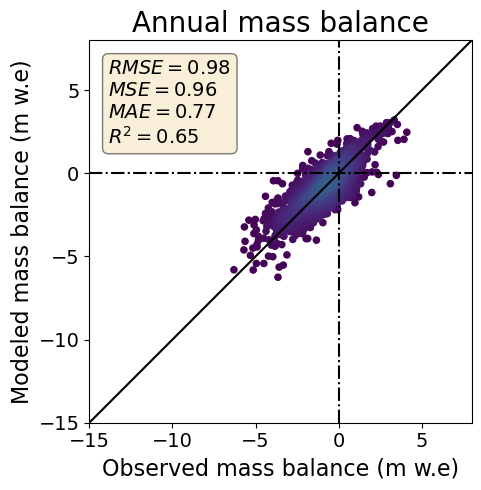

In [235]:
# Sum predictions
y_pred_annual_agg = y_pred_summer_agg + y_pred_winter_agg

# Compare to test annual
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

### 5.2 Full model trained on cluster WITH NORMALIZED FEATURES

In [31]:
# Load model
#loaded_model = CustomXGBRegressor()
#loaded_model.load_model('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')

# Model trained on cluster using up to 0.2 for learning rate. 
# NORMALIZED FEATURES
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
with open('Training_cluster/2024-08-05_15-44-58/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

In [32]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002B570F05900>, ...)

In [52]:
# Load cv-results
#import joblib
#cv_grid = joblib.load('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')
#best_model = cv_grid.best_estimator_

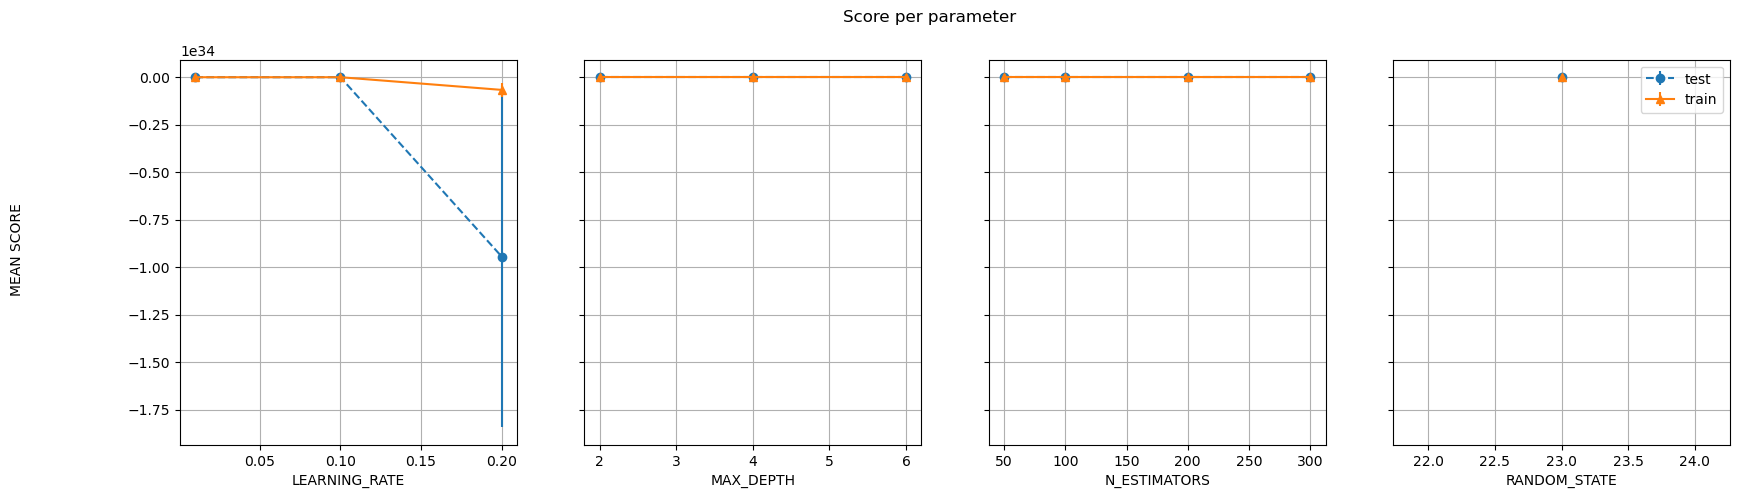

In [33]:
plot_gsearch_results(clf_loaded)

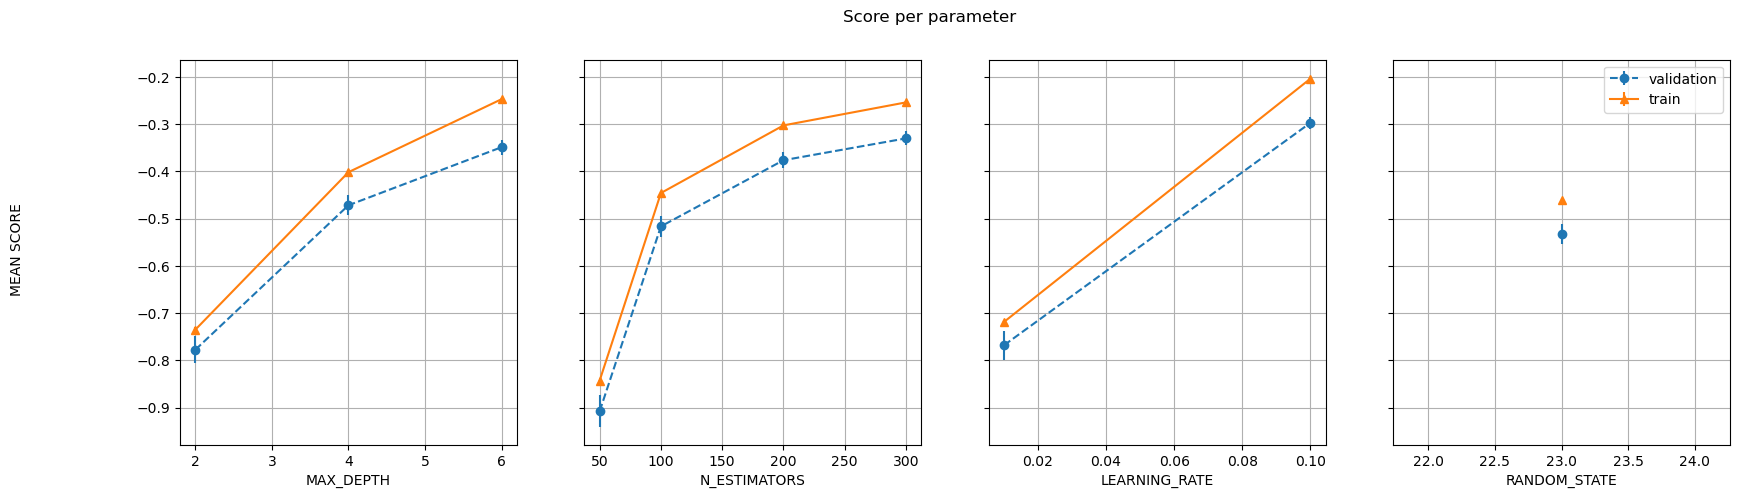

In [35]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.1)

In [61]:
# Load best model refit to all training data
best_model = clf_loaded.best_estimator_

In [62]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002B570F05900>, ...)

In [63]:
test_pred = best_model.predict(X_test)

In [64]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


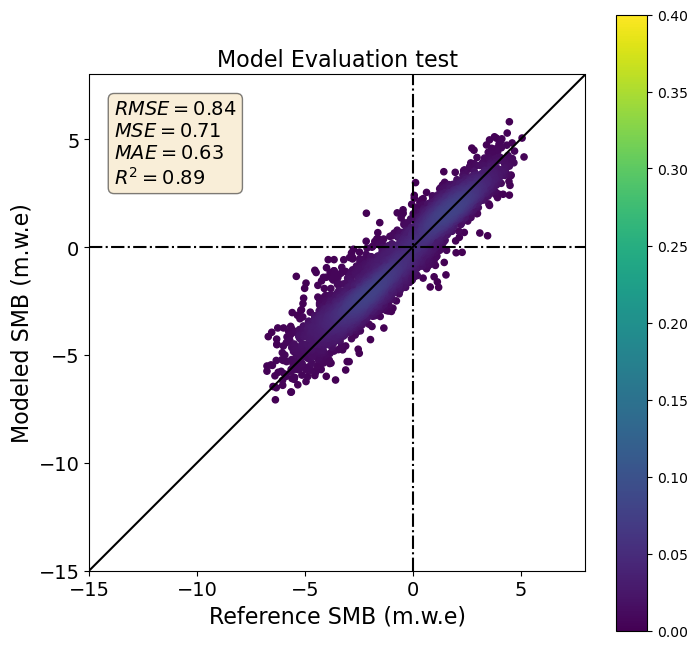

In [65]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

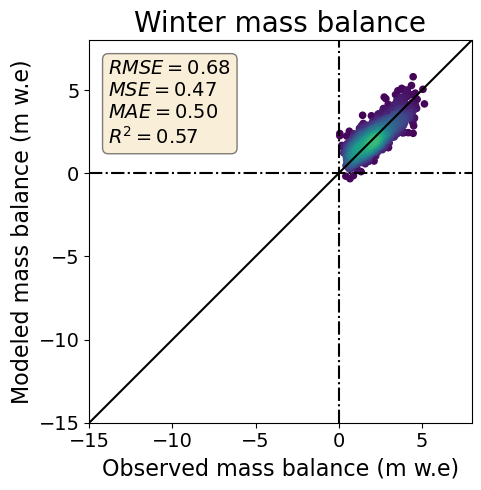

In [67]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

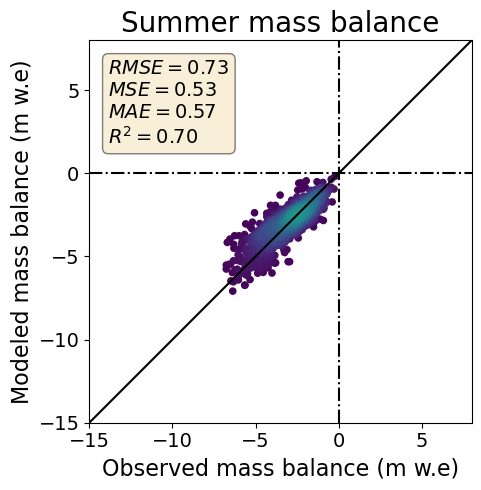

In [68]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

In [70]:
y_pred_annual_agg.shape

(1065,)

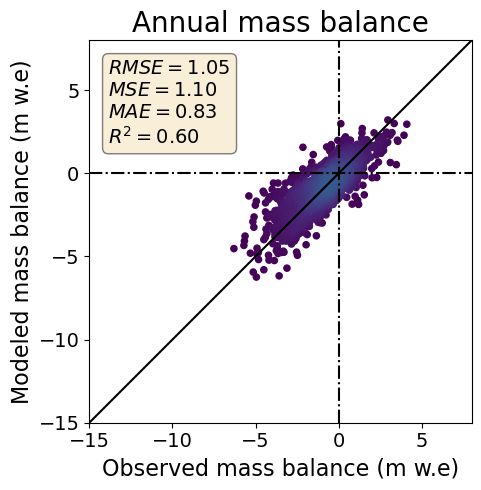

In [69]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

## 5.3 Test custom loss updated with more efficient code from Julian 

In [37]:
# Model trained on cluster using up to 0.2 for learning rate. 
# USING UPDATED VERSION OF CustomXGBRegressor from Julian
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
with open('Training_cluster/2024-08-06_10-50-40/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

In [38]:
clf_loaded.best_estimator_


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000022ED63EE950>, ...)

In [52]:
# Load cv-results
#import joblib
#cv_grid = joblib.load('Models/Custom_loss/2024-06-14_19-29-23/custom_loss_best_model.bin')
#best_model = cv_grid.best_estimator_

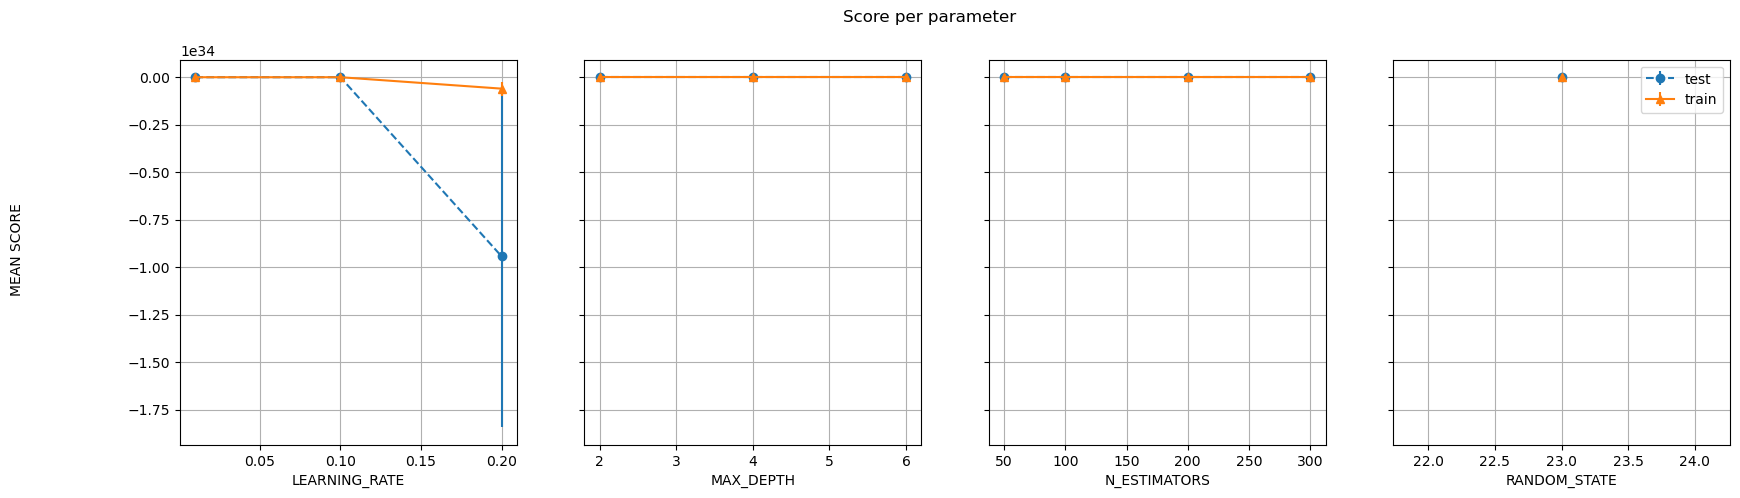

In [39]:
plot_gsearch_results(clf_loaded)

In [40]:

def plot_gsearch_results_mod(grid, learning_rate_threshold=0.3):
    """
    Params: 
        grid: A trained GridSearchCV object.
        learning_rate_threshold: The maximum learning rate to include in the plot.
    """
    # Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    
    params_list = results['params']

    # Create a mask to filter out parameter combinations with learning rates > threshold
    learning_rate_mask = [param['learning_rate'] <= learning_rate_threshold for param in params_list]
    
    filtered_means_test = means_test[learning_rate_mask]
    filtered_stds_test = stds_test[learning_rate_mask]
    filtered_means_train = means_train[learning_rate_mask]
    filtered_stds_train = stds_train[learning_rate_mask]
    filtered_params_list = [params_list[i] for i in range(len(params_list)) if learning_rate_mask[i]]

    # Extract the unique values for each parameter to plot
    unique_param_values = {param_name: sorted(set(param_dict[param_name] for param_dict in filtered_params_list))
                           for param_name in grid.param_grid.keys()}

    width = len(grid.param_grid.keys()) * 5

    # Plot results
    fig, ax = plt.subplots(1, len(unique_param_values), sharex='none', sharey='all', figsize=(width, 5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')

    for i, (param_name, param_values) in enumerate(unique_param_values.items()):
        # For each parameter, extract the means and stds of the scores
        param_results_test = {val: [] for val in param_values}
        param_results_train = {val: [] for val in param_values}
        
        for j, params in enumerate(filtered_params_list):
            param_results_test[params[param_name]].append((filtered_means_test[j], filtered_stds_test[j]))
            param_results_train[params[param_name]].append((filtered_means_train[j], filtered_stds_train[j]))

        # Aggregate the results for plotting
        x = param_values
        y_test = [np.mean([score[0] for score in param_results_test[val]]) for val in x]
        e_test = [np.mean([score[1] for score in param_results_test[val]]) for val in x]
        y_train = [np.mean([score[0] for score in param_results_train[val]]) for val in x]
        e_train = [np.mean([score[1] for score in param_results_train[val]]) for val in x]

        ax[i].errorbar(x, y_test, e_test, linestyle='--', marker='o', label='validation')
        ax[i].errorbar(x, y_train, e_train, linestyle='-', marker='^', label='train')
        ax[i].set_xlabel(param_name.upper())
        ax[i].grid()

    plt.legend()
    plt.show()


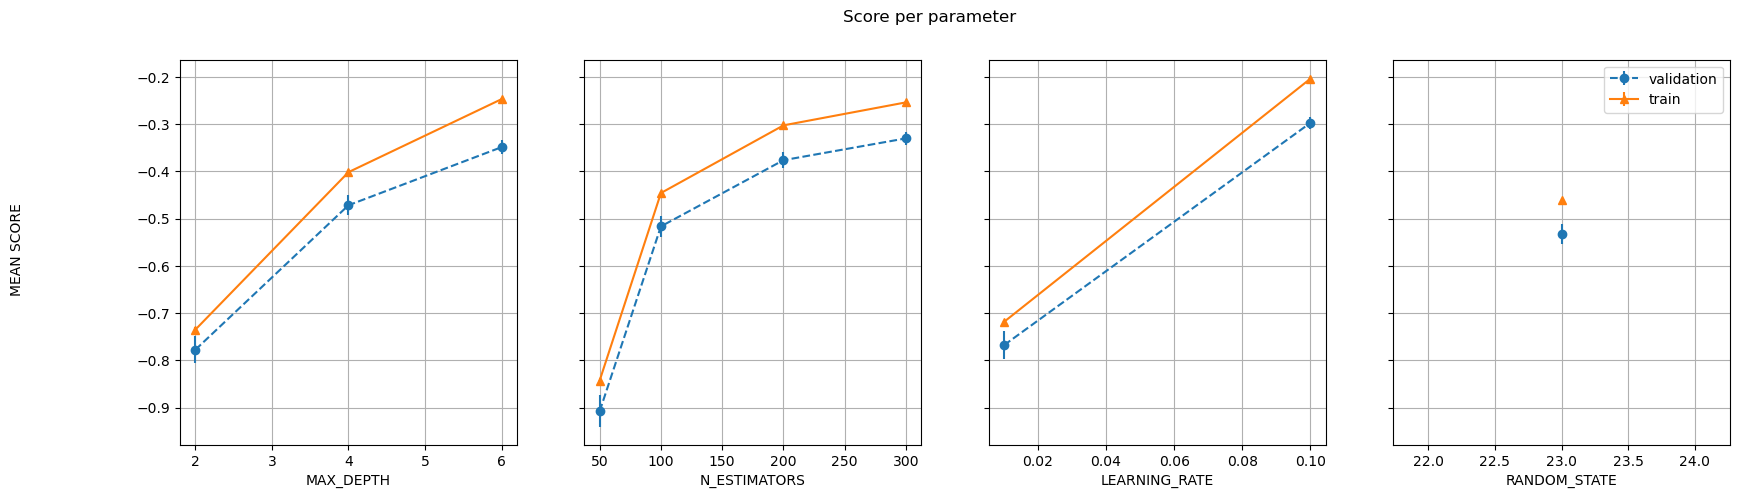

In [41]:
plot_gsearch_results_mod(clf_loaded, learning_rate_threshold=0.1)

In [42]:
# Load best model refit to all training data
best_model = clf_loaded.best_estimator_

In [43]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=6, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=300, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000022ED63EE950>, ...)

In [44]:
test_pred = best_model.predict(X_test)

In [45]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


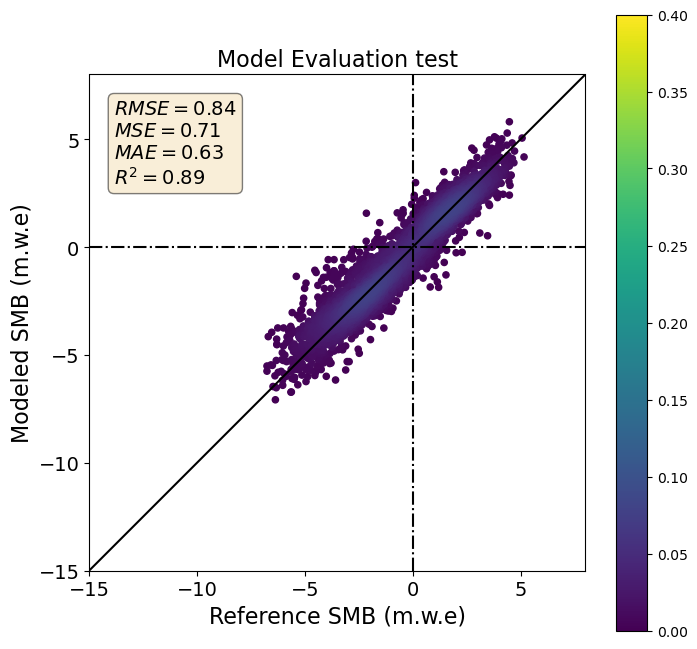

In [46]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

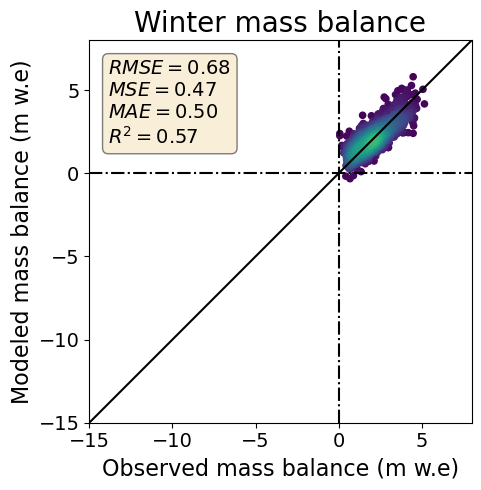

In [48]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

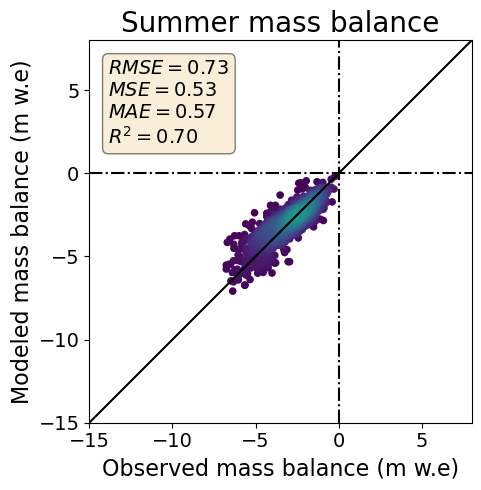

In [49]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

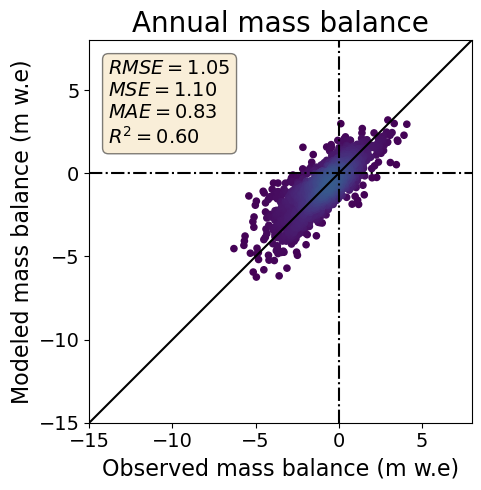

In [51]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

## 5.4 Test with ssr_net instead of ssr_down and fal

In [154]:
#best_model = clf_loaded.best_estimator_
#best_model.fit(X_train, y_train)
best_model = CustomXGBRegressor(max_depth=7, learning_rate=0.1, gamma=10, n_estimators=800)
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:28:12] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=10,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=800, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000002C38B292680>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


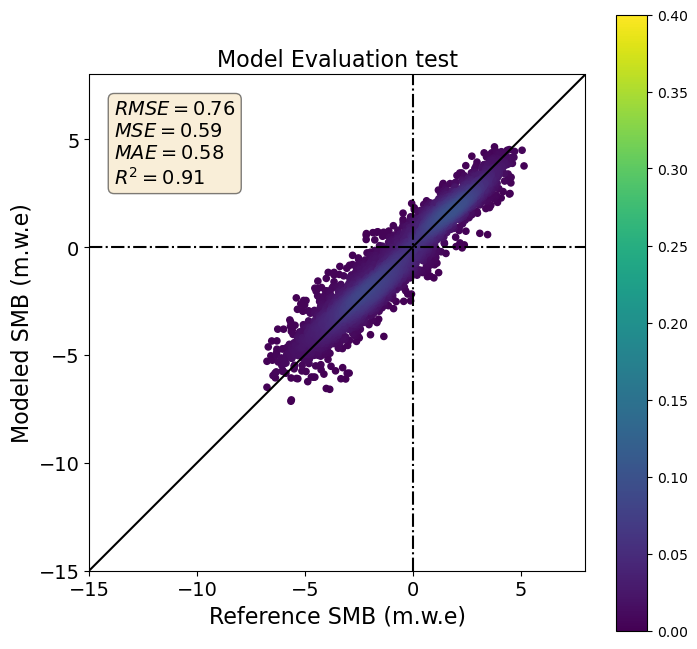

In [155]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

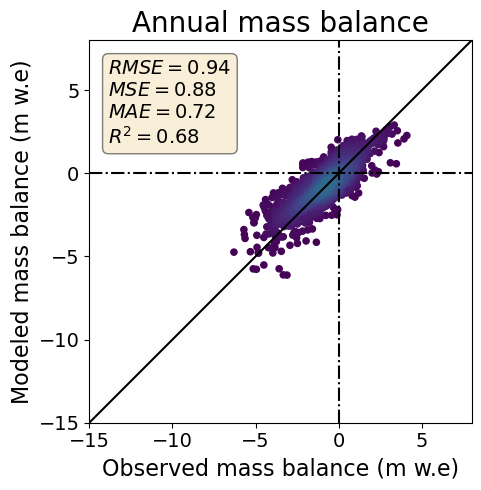

In [156]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

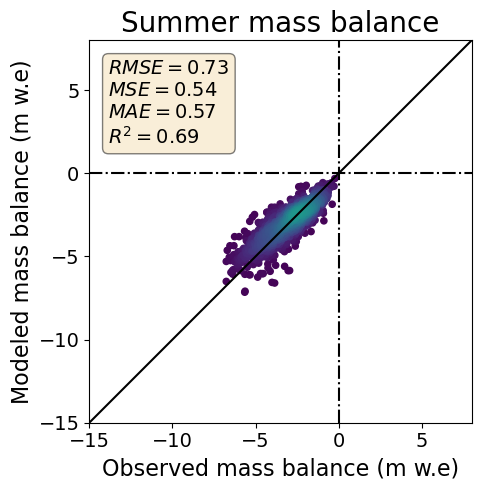

In [157]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

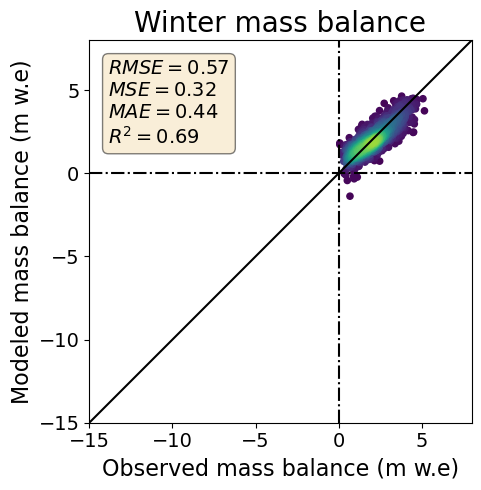

In [158]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

## 5.5 Test with only prec and temp

In [196]:
best_model = clf_loaded.best_estimator_
best_model.fit(X_train, y_train)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:01:34] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "metadata_shape" } are not used.

  warnings.warn(smsg, UserWarning)


CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=None,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.1,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=7, max_leaves=None,
                   min_child_weight=None, missing=nan,
                   monotone_constraints=None, multi_strategy=None,
                   n_estimators=700, n_jobs=None, num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000024F61E751B0>, ...)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


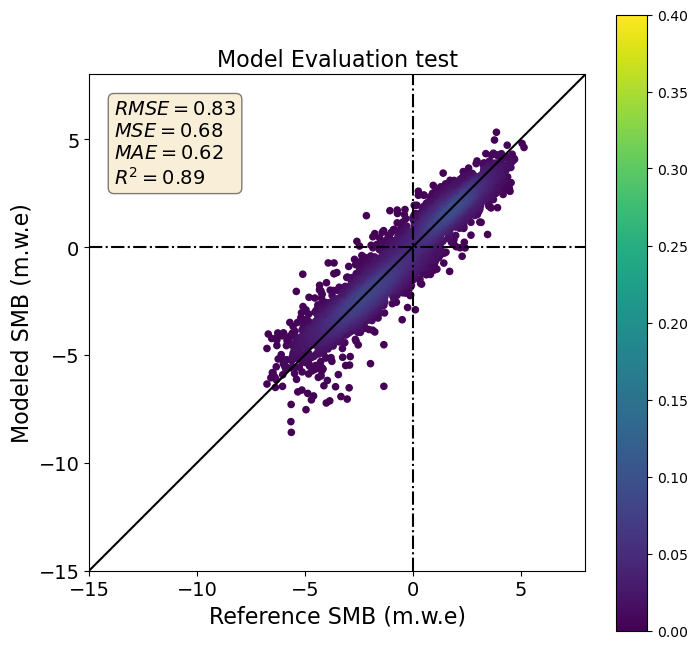

In [199]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

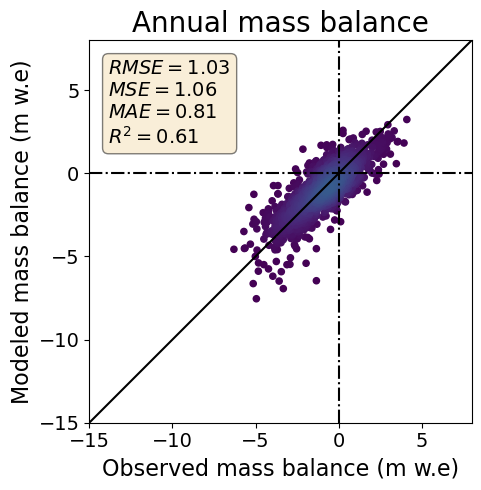

In [200]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)
plot_prediction_per_season(y_test_annual_mean, y_pred_annual_agg, season='Annual')

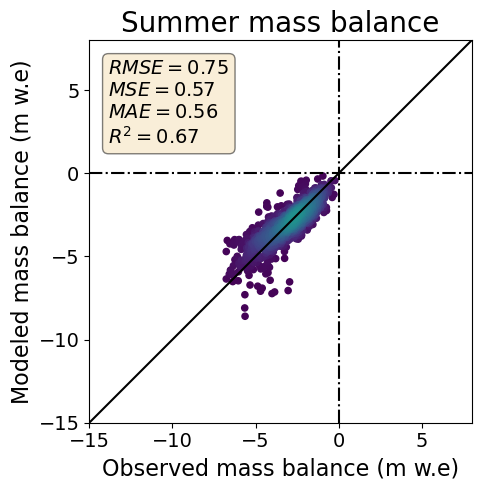

In [201]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)
plot_prediction_per_season(y_test_summer_mean, y_pred_summer_agg, season='Summer')

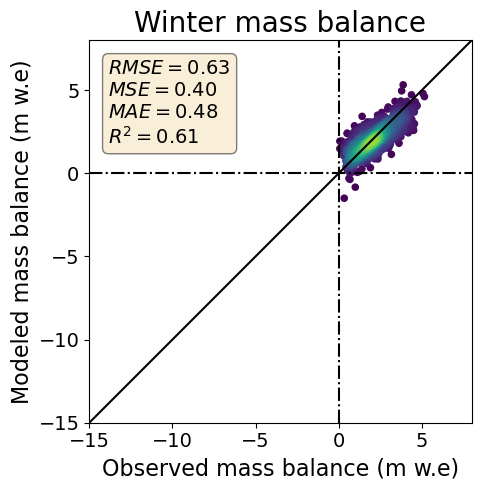

In [202]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)
plot_prediction_per_season(y_test_winter_mean, y_pred_winter_agg, season='Winter')

# 6 Test

In [63]:
# Make predictions on test data
test_pred = xgb_model.predict(X_test)

In [64]:
# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


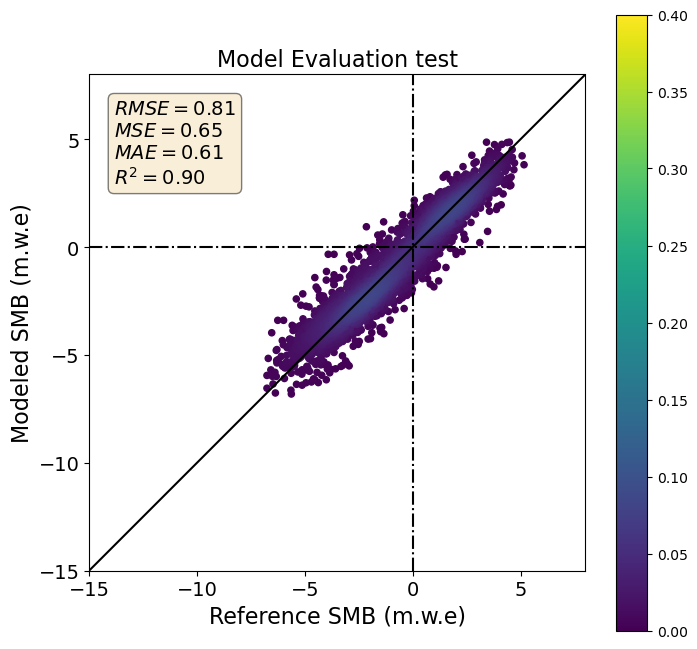

In [65]:
# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

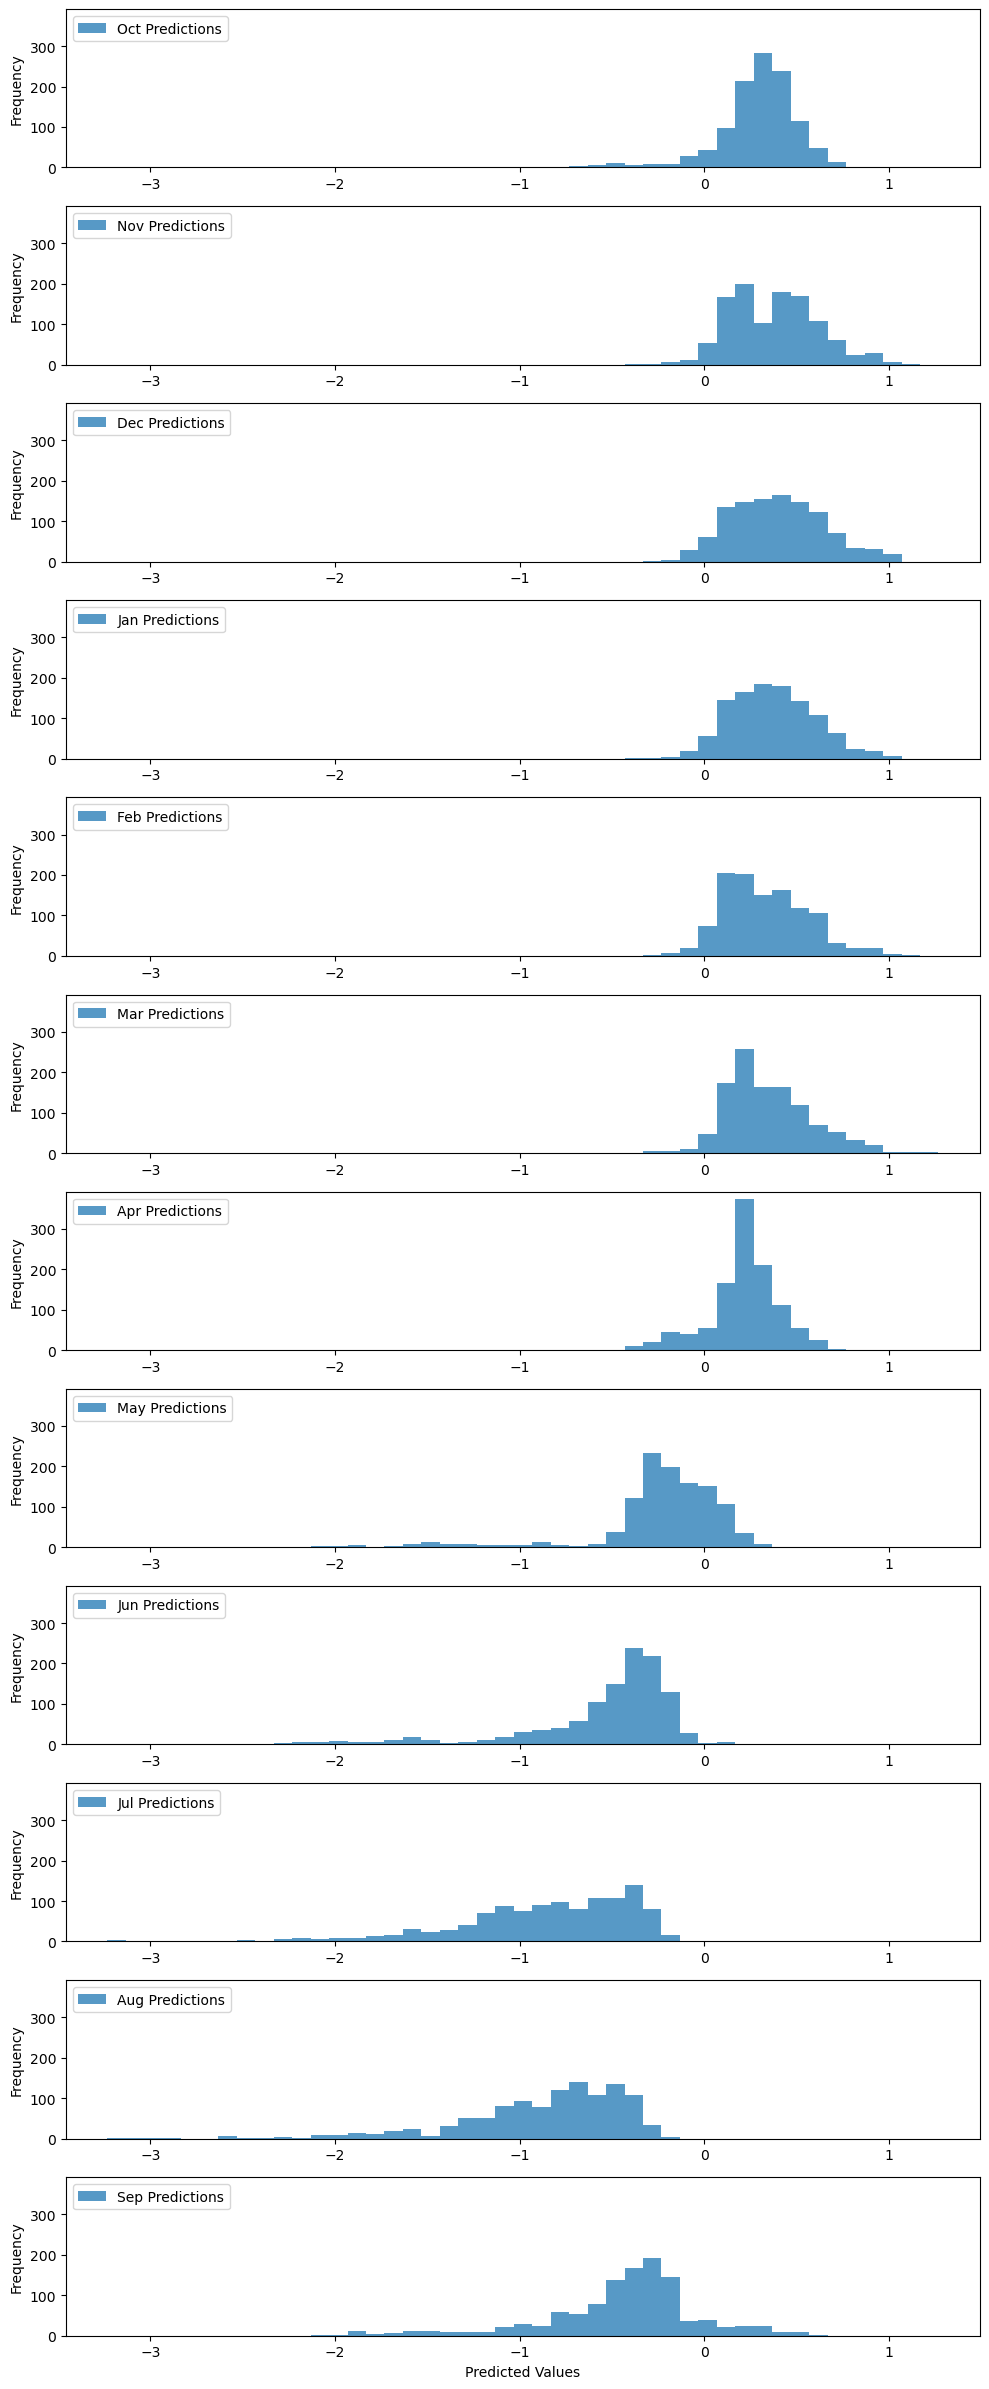

In [56]:
# Plot predicted mass balance distribution for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]

# Define the month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']

bin_width = 0.1 

min_pred = predictions.min()
max_pred = predictions.max()

# Create bins with the specified width from the global min to max prediction
bins = np.arange(min_pred, max_pred + bin_width, bin_width)

fig, ax = plt.subplots(len(month_order), 1, figsize=(10, 2*len(month_order)), sharex = True, sharey=True)

for i, month in enumerate(month_order):
    month_predictions = predictions[months == month]
    
    ax[i].hist(month_predictions, bins=bins, alpha=0.75, label=f'{month.capitalize()} Predictions')

    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    
    ax[i].set_ylabel('Frequency')
    ax[i].legend(loc='upper left')

ax[-1].set_xlabel('Predicted Values')

plt.tight_layout()

plt.show()

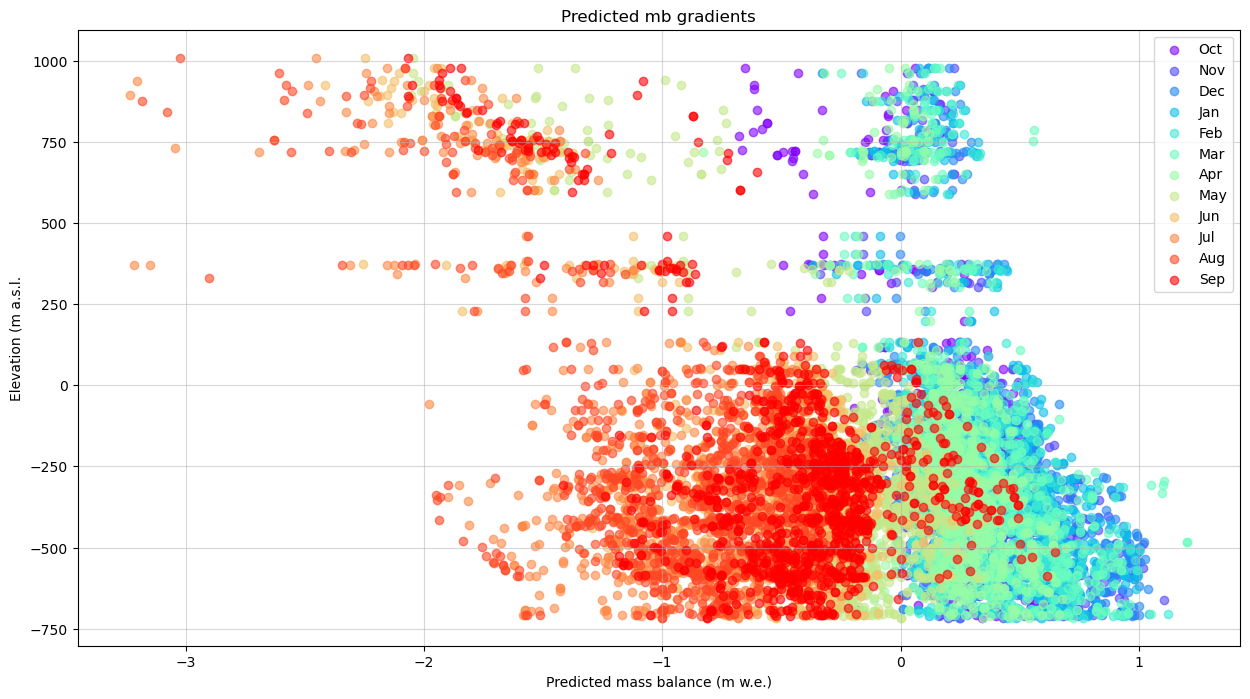

In [57]:
# Plot predicted mass balance gradient for each month

import matplotlib.pyplot as plt

months = X_val_crop[:,-1]
elevation = X_val_crop[:,0]

# Define month order
month_order = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']
colors = plt.cm.rainbow(np.linspace(0, 1, len(month_order)))

# Map month to color
month_to_color = dict(zip(month_order, colors))

fig, ax = plt.subplots(figsize=(15, 8))

for month in month_order:
    idx = months == month
    ax.scatter(predictions[idx], elevation[idx], label=month.capitalize(), alpha=0.6, c=[month_to_color[month]])

ax.set_xlabel('Predicted mass balance (m w.e.)')
ax.set_ylabel('Elevation (m a.s.l.')
ax.set_title('Predicted mb gradients')
ax.legend()

plt.grid(alpha=0.5)
plt.show()